# Step 1. 데이터 다운로드 (로컬 유저용)

아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

_💡이전 [ Seq2seq으로 번역기 만들기 ] 코스에서 사용한 데이터와 동일한 데이터입니다!_

터미널을 열어서 하단의 명령어를 입력해주시면 됩니다.

```
$ mkdir -p ~/aiffel/transformer/data
$ cd ~/aiffel/transformer/data

$ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
$ gzip -d korean-english-park.train.tar.gz
$ tar -xvf korean-english-park.train.tar
```

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import sequence

import re
import os
import io
import time
import random

from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab
from tqdm import tqdm
from tqdm import tqdm_notebook
import sentencepiece as spm
import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.4.1


In [2]:
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("슝=3")

슝=3


---

# Step 2. 데이터 정제 및 토큰화

1) set 데이터형이 __중복을 허용하지 않는다는 것을 활용__해 중복된 데이터를 제거하도록 합니다. 데이터의 __병렬 쌍이 흐트러지지 않게 주의__하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

## 데이터 로드 및 중복 제거

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)
len(cleaned_corpus)

78968

In [4]:
cleaned_corpus[100]

('그들의 해악적 유머는 청중들이 느낄 수 있는 많은 얘기를 하며 그들에게 즐거움을 주고 있다.',
 'Their biting humor is something to which many in their audience can relate.')

2) 정제 함수를 아래 조건을 만족하게 정의하세요.

## 정제 함수 생성

>___조건___
>- _모든 입력을 ___소문자로 변환___합니다._
>- ___알파벳, 문장부호, 한글___ _만 남기고 모두 제거합니다._
>- ___문장부호 양옆에 공백___ _을 추가합니다._
>- _문장 앞뒤의 ___불필요한 공백을 제거___합니다._

In [6]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower()

    sentence = re.sub(r"([?.!,¿¡])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-하-ㅣ가-힣0-9?.!,]+", " ", sentence) 

    sentence = sentence.strip()
    
    return sentence

3) 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, __정제하여 토큰화를 진행__합니다! __토큰화에는 Sentencepiece를 활용__하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 __타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게__ 합니다.

> ___조건___
>- _단어 사전을 매개변수로 받아 ___원하는 크기의 사전을 정의___할 수 있게 합니다. (기본: 20,000)_
>- _학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다._
>- ___특수 토큰의 인덱스___ _를 아래와 동일하게 지정합니다._  
_\<PAD> : 0 / \<BOS> : 1 /  
\<EOS> : 2 / \<UNK> : 3_

- 참고: [google/sentencepiece](https://github.com/google/sentencepiece)

## 데이터 분할 정제

In [7]:
kor_corpus = []
eng_corpus = []

for sentence in cleaned_corpus:
    ko_sentence = preprocess_sentence(sentence[0])
    en_sentence = preprocess_sentence(sentence[1])
    kor_corpus.append(ko_sentence)
    eng_corpus.append(en_sentence)   
    
print(len(eng_corpus))
print(len(kor_corpus))

78968
78968


In [9]:
print("Korean :", kor_corpus[100])   
print("English :", eng_corpus[100])

Korean : 그들의 해악적 유머는 청중들이 느낄 수 있는 많은 얘기를 하며 그들에게 즐거움을 주고 있다 .
English : their biting humor is something to which many in their audience can relate .


## 데이터 토큰화 : Sentencepiece

In [12]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):

    model_name = 'spm_GD10_'+lang

    # 모델 생성 경로
    temp_file = os.getenv(
        'HOME')+'/aiffel/transformer/data/spm/GD10_'+lang+'.ko'

    # 함수 파라미터 lang의 단어를 적용한 파일 코퍼스 파일 만듬
    with open(temp_file, 'w') as f:
        for row in corpus:   # lang corpus를 활용합니다.
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train(
        '\
        --input={} \
        --model_prefix={} \
        --vocab_size={} \
        --pad_id={} \
        --bos_id={} \
        --eos_id={} \
        --unk_id={}'.format(temp_file, model_name, vocab_size, pad_id, bos_id, eos_id, unk_id)
    )
    # 위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(model_name+'.model')

    return tokenizer

In [13]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

4) 토크나이저를 활용해 __토큰의 길이가 50 이하__인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

## 토크나이징 & 텐서 변환

In [14]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    token_ko = ko_tokenizer.encode_as_ids(kor_corpus[idx])
    token_en = en_tokenizer.encode_as_ids(eng_corpus[idx])
               
    if len(token_ko) <= 50  and len(token_en) <= 50:
        src_corpus.append(token_ko)
        tgt_corpus.append(token_en)

print(len(src_corpus))
print(len(tgt_corpus))

/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/78968 [00:00<?, ?it/s]

67942
67942


In [15]:
print("Korean :", src_corpus[100])   
print("English :", tgt_corpus[100])

Korean : [16, 7, 570, 337, 1550, 26, 1348, 3064, 10, 564, 21, 8823, 6, 1639, 5]
English : [1, 30, 1354, 9, 265, 28, 11, 1199, 120, 18, 3964, 377, 47, 290, 9, 71, 11, 3821, 12, 5, 119, 14, 4138, 10, 5, 246, 6, 1277, 18, 3713, 34, 5, 3221, 7, 2]


In [16]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

In [17]:
print(enc_train.shape)
print(dec_train.shape)

(67942, 50)
(67942, 50)


---

# tep 3. 모델 설계

오늘 배운 내용을 활용해서 Transformer 모델을 설계해보세요!

## Positional Encoding

In [18]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

print("슝=3")

슝=3


## Multi-Head Attention

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

## Position-wise Feed-Forward Network

In [20]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


## Encoder 레이어 구현

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


## Decoder 레이어 구현

In [22]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

## Encoder 클래스 정의

In [29]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


## Decoder 클래스 정의

In [30]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


## Transformer 클래스 정의

In [31]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

## Masking

In [32]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


In [43]:
def generate_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [44]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

## LearningRateSchedule 클래스 정의

In [47]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

print("슝=3")

슝=3


---

# Step 4. 훈련하기

앞서 필요한 것들을 모두 정의했기 때문에 우리는 훈련만 하면 됩니다! 아래 과정을 차근차근 따라가며 모델을 훈련하고, __예문에 대한 멋진 번역__을 제출하세요!

## Transformer 선언

1. __2 Layer__를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)

In [48]:
transformer = Transformer(
    n_layers = 2,
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=50,
    dropout = 0.3
)

## Optimizertion

2. 논문에서 사용한 것과 동일한 __Learning Rate Scheduler__를 선언하고, 이를 포함하는 __Adam Optimizer__를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [49]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-09, 
    name='Adam'
)

## Loss

3. __Loss 함수를 정의__하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, __Masking 되지 않은 입력의 개수로 Scaling__하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## Train Step

4. __train_step 함수__를 정의하세요.
__입력 데이터에 알맞은 Mask를 생성__하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [51]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

## 모델 학습

5. __학습을 진행__합니다.
__매 Epoch 마다 제시된 예문에 대한 번역을 생성__하고, 멋진 번역이 생성되면 그때의 __하이퍼파라미터와 생성된 번역을 제출__하세요!

__예문__
``` python
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.
```

__결과(output)__
``` python
Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 5
```

번역 생성에는 아래 소스를 사용하시길 바랍니다!

In [52]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [53]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [54]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

translate() 함수의 plot_attention 변수를 True 로 주면 번역 결과에 대한 Attention Map을 시각화 해볼 수 있습니다.

💡 이번 프로젝트에서 제시한 예문은 Seq2seq으로 번역기 만들기의 예문과 동일합니다. Seq2seq과 Transformer로 만든 두 번역기의 성능을 하이퍼파라미터를 조정 등 다양한 연구해보시면 학습에 도움이 되실 거예요!

마지막으로, 학습의 전 과정을 구현한 코드를 첨부합니다. 구현과정에 참고해 주세요. 수고하셨습니다!!

``` python
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
```

In [55]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 32
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president elect barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the world s largest .
Input: 커피는 필요 없다.
Predicted translation: it s not about anyone .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s campaign is a president of president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city of city .
Input: 커피는 필요 없다.
Predicted translation: you can t know you re going to be a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was the death toll .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first cnn .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the mountain .
Input: 커피는 필요 없다.
Predicted translation: there are no need need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people were killed .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a city .
Input: 커피는 필요 없다.
Predicted translation: coffee is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a nearby town .
Input: 커피는 필요 없다.
Predicted translation: there s no choice for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven others were killed and seven were in the last seven .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is also a mountain in  ⁇ 
Input: 커피는 필요 없다.
Predicted translation: there s no need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed were also killed .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big sign for the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: among the city is in that city .
Input: 커피는 필요 없다.
Predicted translation: no need is need to speak .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed when a seven were struck .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is largely a mountain .
Input: 커피는 필요 없다.
Predicted translation: no need is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed when they were taken .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is there .
Input: 시민들은 도시 속에 산다.
Predicted translation: among the city is largely a mountain .
Input: 커피는 필요 없다.
Predicted translation: no need is need for coffee anything .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed when the seven were seen on board a takes-off dressed in the seven .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the nation .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens is in spot for the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee needs to speak .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven-member them where .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama has a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are large .
Input: 커피는 필요 없다.
Predicted translation: the coffee needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed were injured .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in the city .
Input: 커피는 필요 없다.
Predicted translation: there s no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are killed .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama has a 2-year-old president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens is in the city .
Input: 커피는 필요 없다.
Predicted translation: there s no need for coffee a must be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven have fled their homes .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee needs no need to speak . coffee is a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed were killed .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is at the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens is in place .
Input: 커피는 필요 없다.
Predicted translation: there s no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths are , according to cases .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: tuesday s city outside of citizens are large .
Input: 커피는 필요 없다.
Predicted translation: don t need to m coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have died , according to estimates .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of .
Input: 시민들은 도시 속에 산다.
Predicted translation: tuesday is just a mountain .
Input: 커피는 필요 없다.
Predicted translation: it s no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven have killed .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is desperate .
Input: 시민들은 도시 속에 산다.
Predicted translation: among the city . . on the city of yangon is there .
Input: 커피는 필요 없다.
Predicted translation: there s no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the killed were wounded , according to the report .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a ideal president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in that city into city .
Input: 커피는 필요 없다.
Predicted translation: there s no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven have died , with seven hours later , the deaths were confirmed .


  0%|          | 0/2124 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama has a couple of americans .
Input: 시민들은 도시 속에 산다.
Predicted translation: among the city is there is known to have in the mountains .
Input: 커피는 필요 없다.
Predicted translation: the need is no alternative .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed when the plane occurred .


---

# 번역 결과 시각화

Input: 오바마는 대통령이다.
Predicted translation: obama has a couple of americans .
Encoder Layer 1


/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


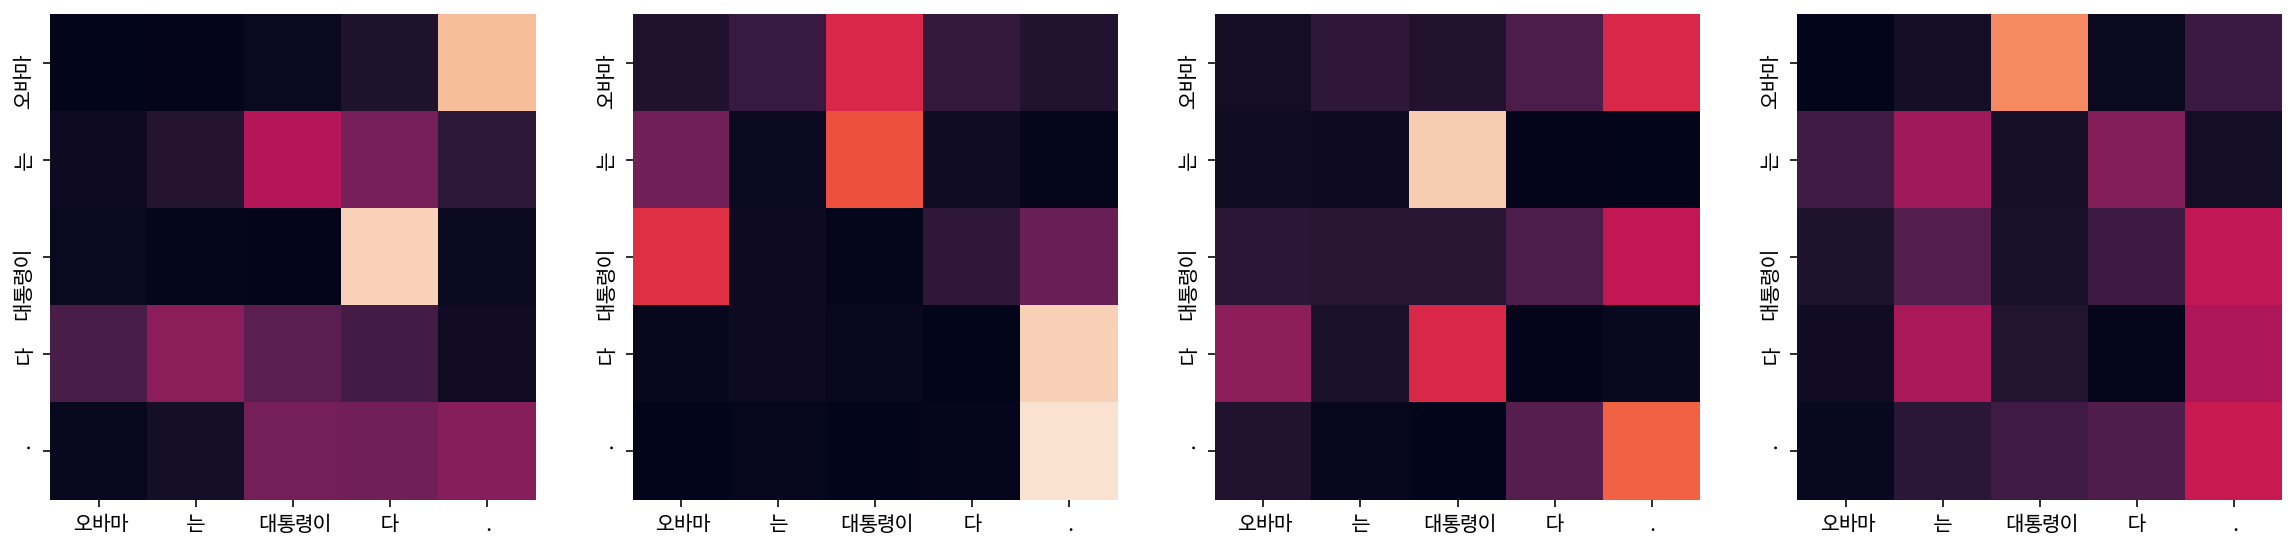

Encoder Layer 2


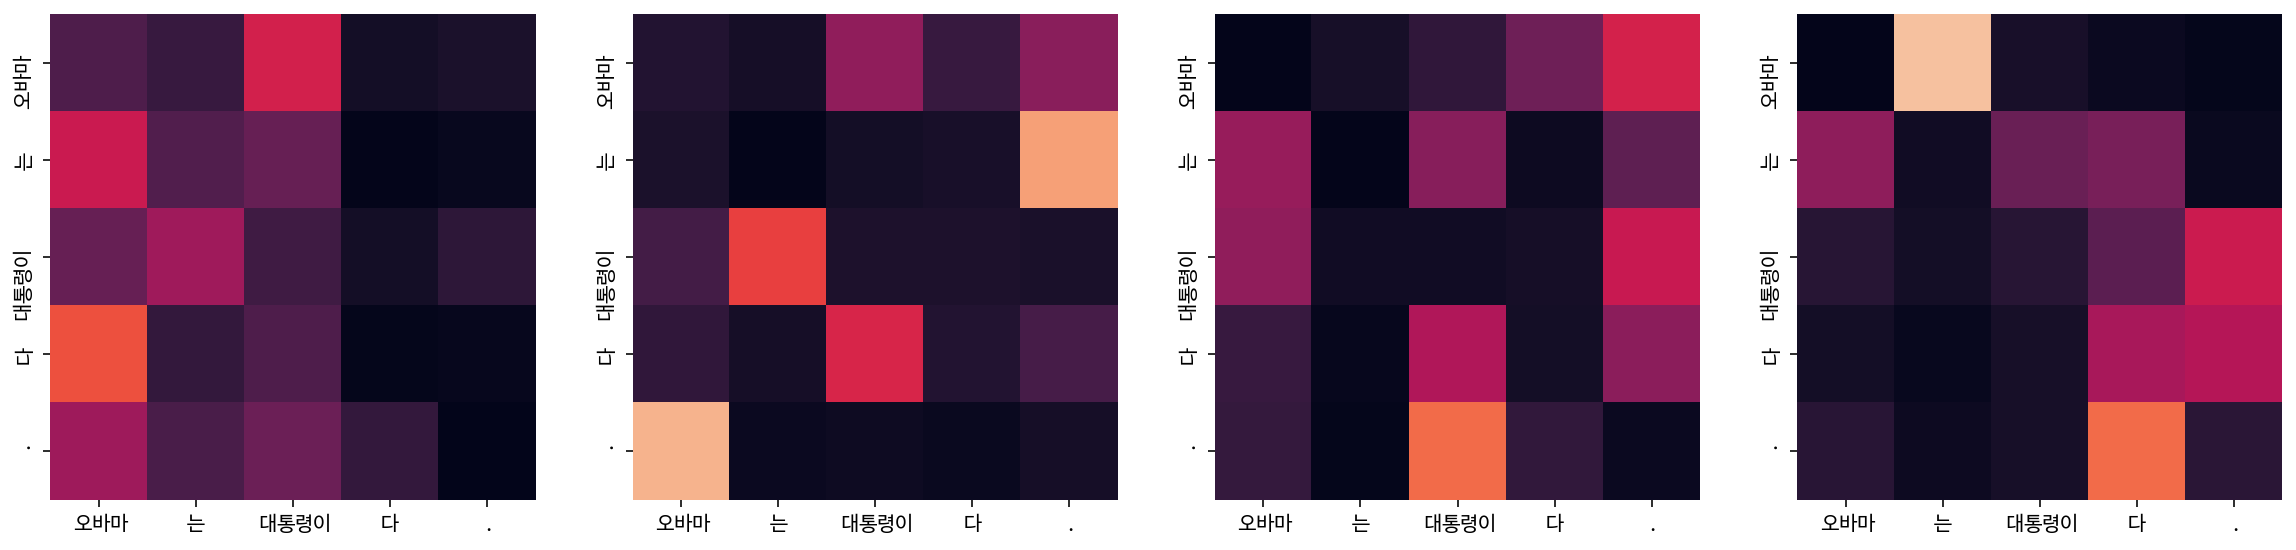

Decoder Self Layer 1


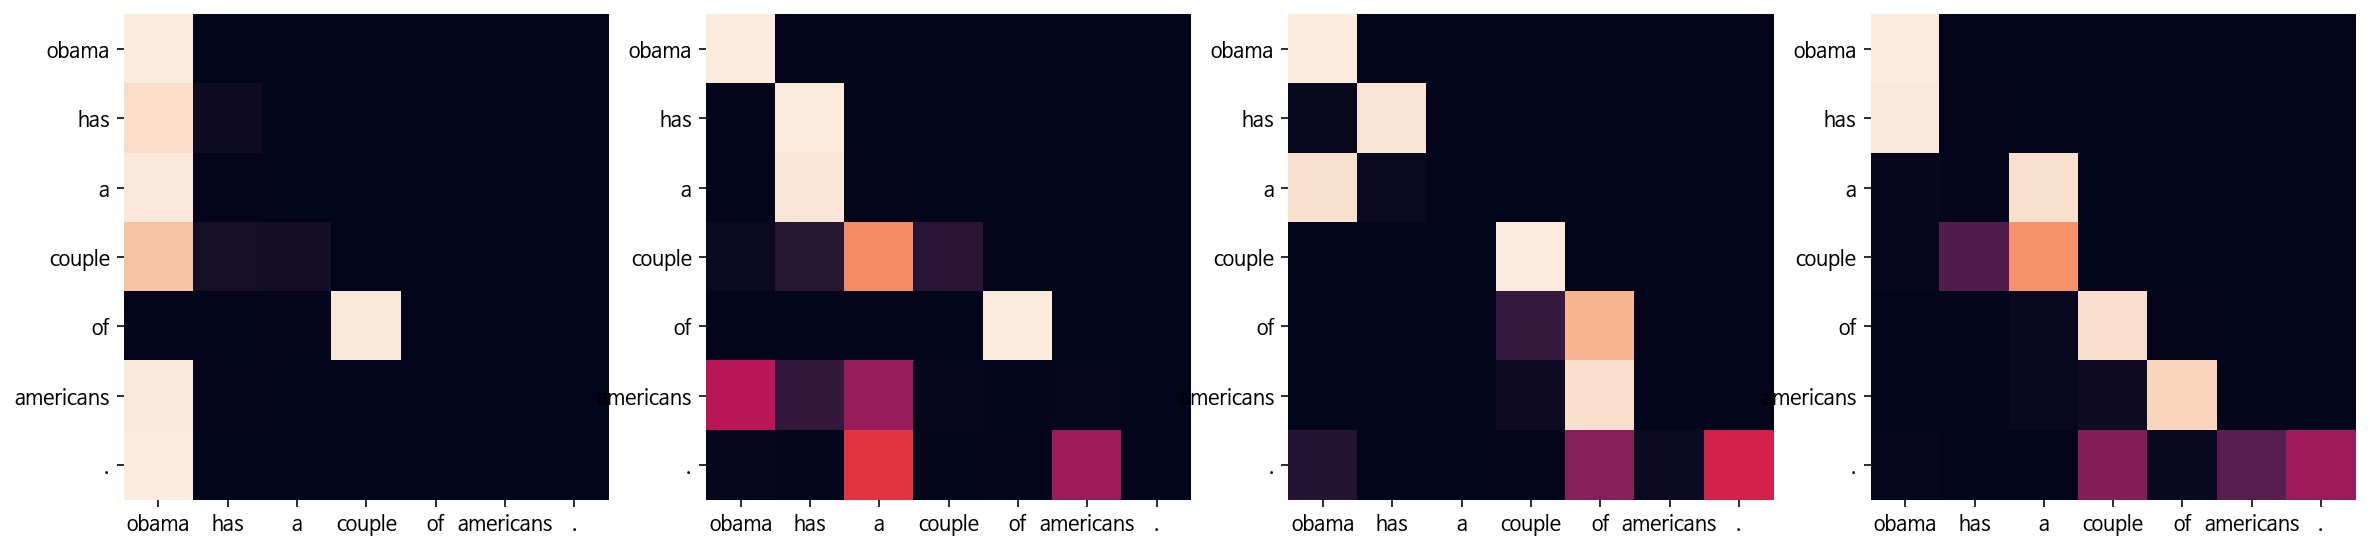

Decoder Src Layer 1


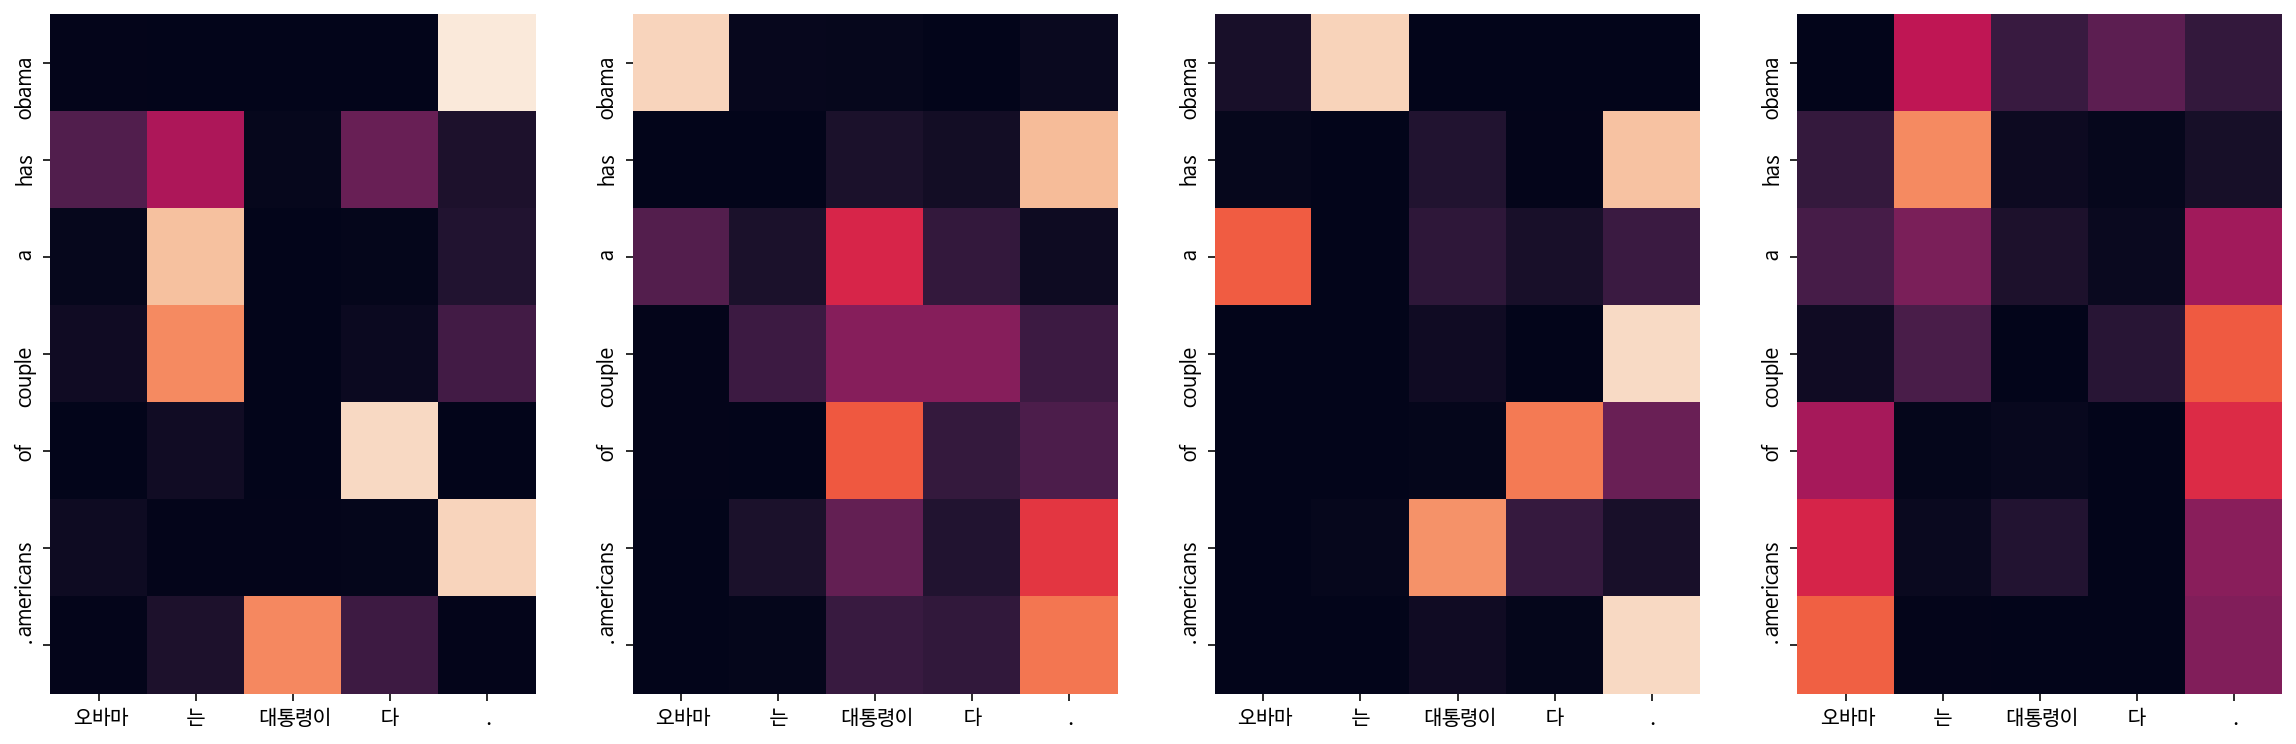

Decoder Self Layer 2


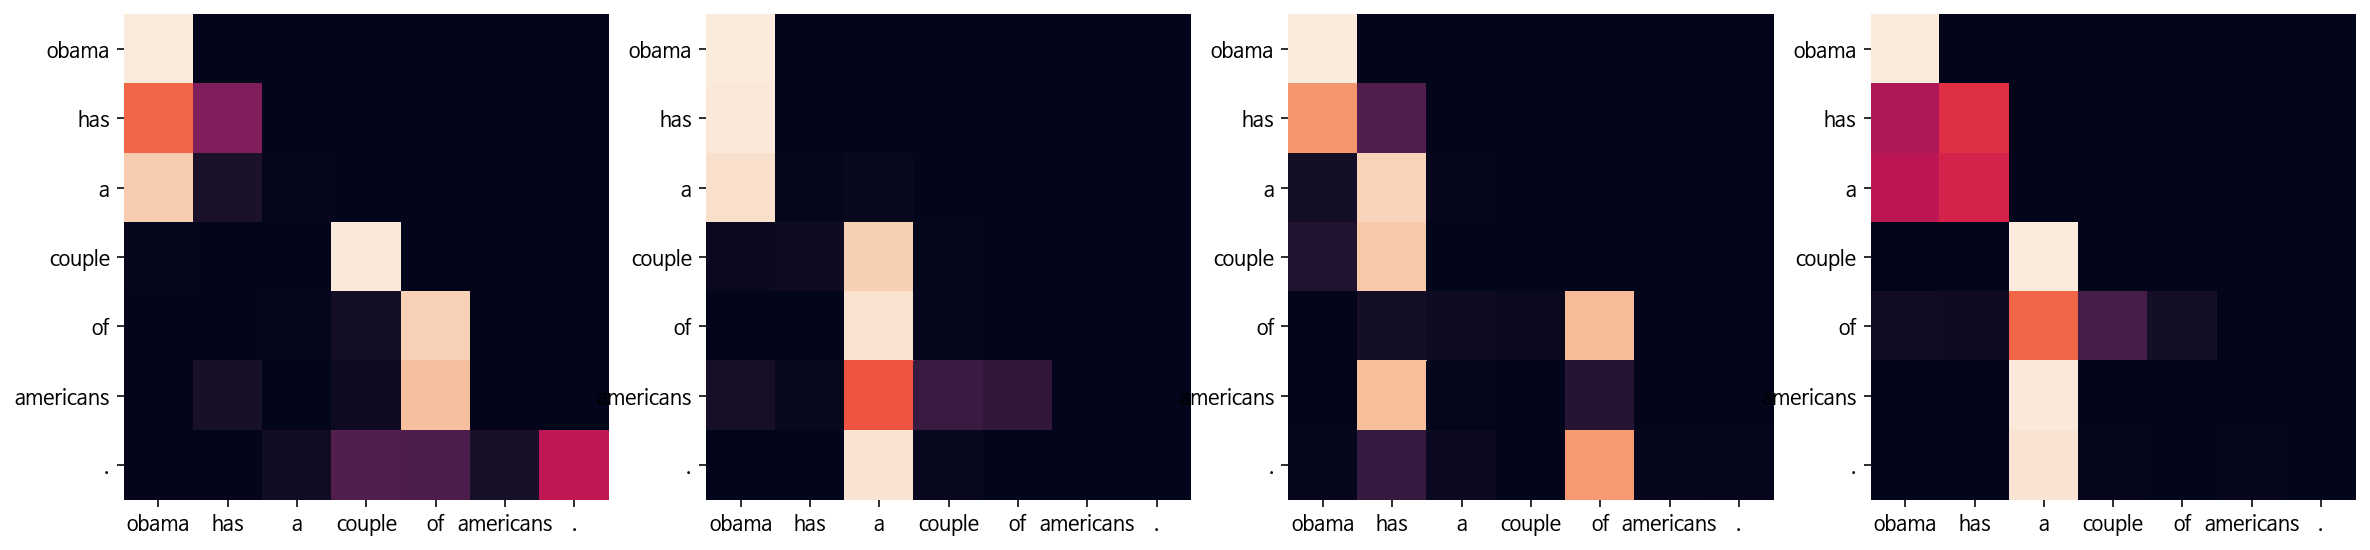

Decoder Src Layer 2


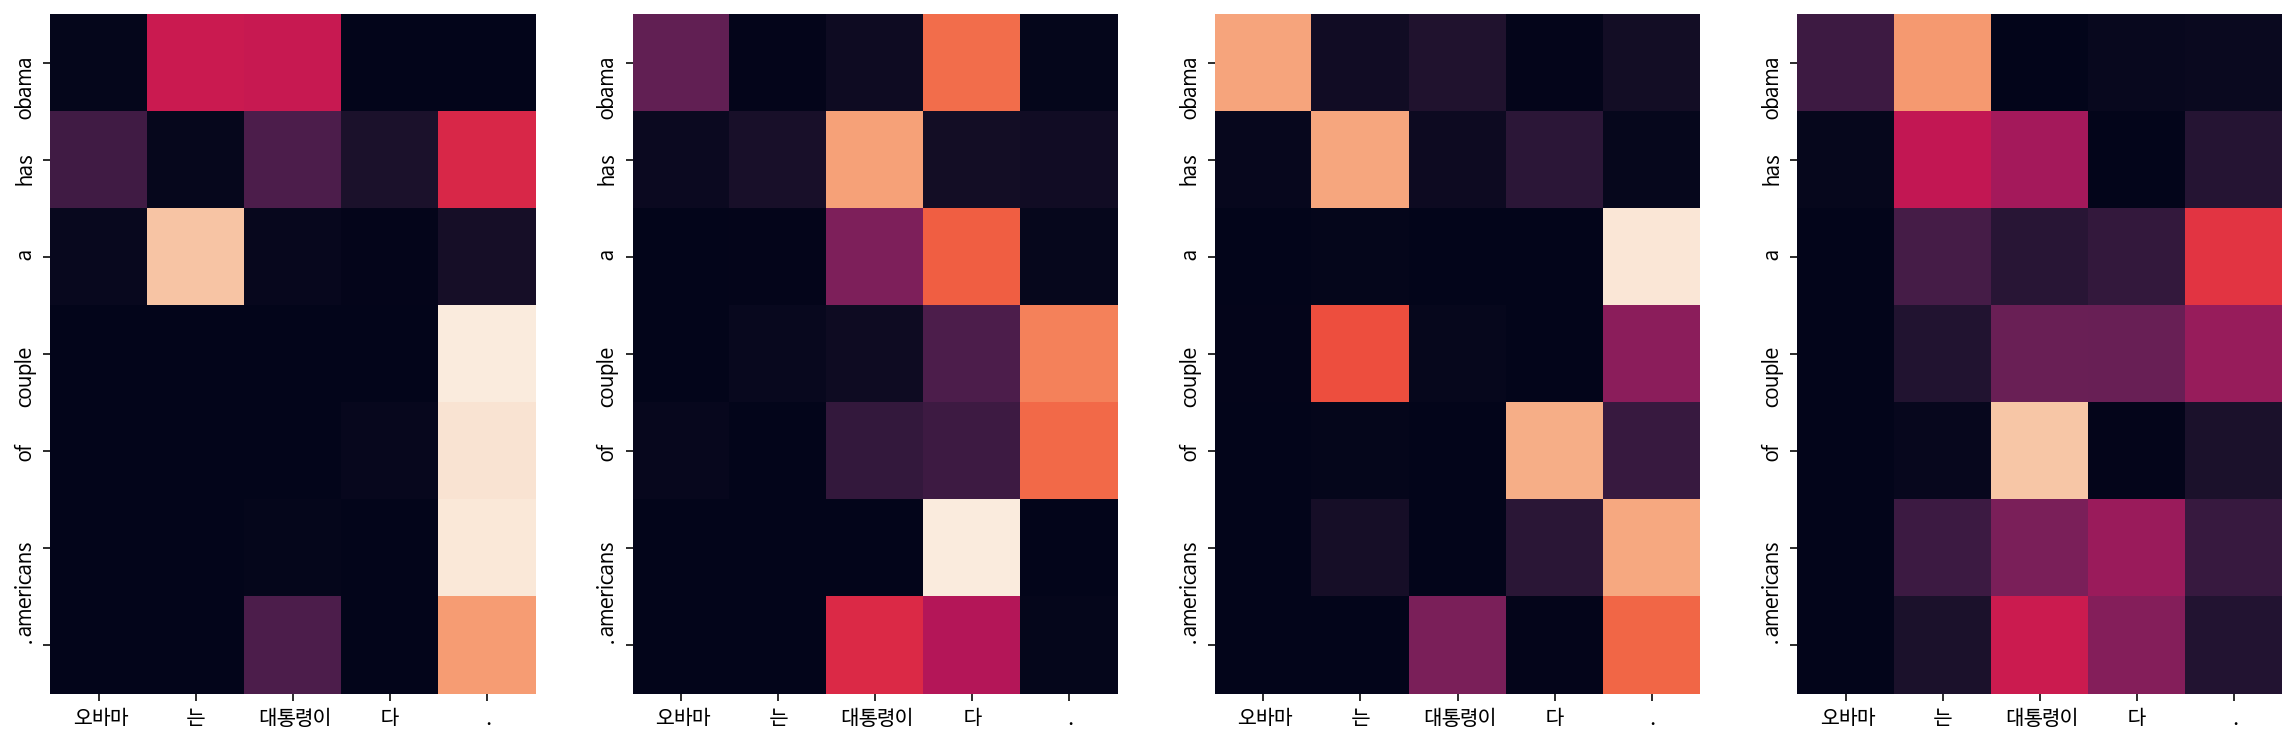

In [56]:
# 오바마는 대통령이다.
translate('오바마는 대통령이다.',transformer, ko_tokenizer, en_tokenizer,True)

Input: 시민들은 도시 속에 산다.
Predicted translation: among the city is there is known to have in the mountains .
Encoder Layer 1


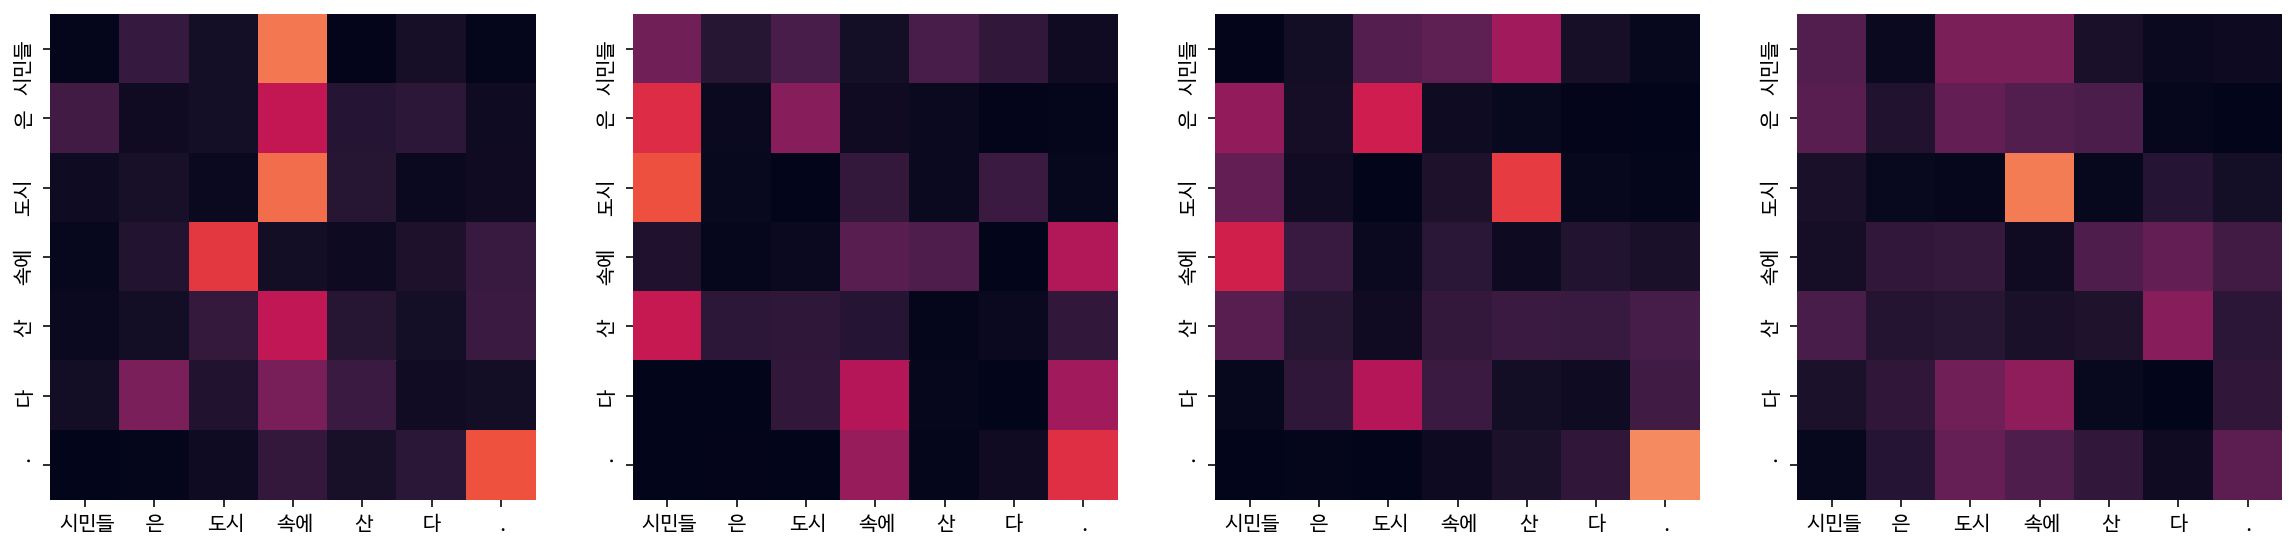

Encoder Layer 2


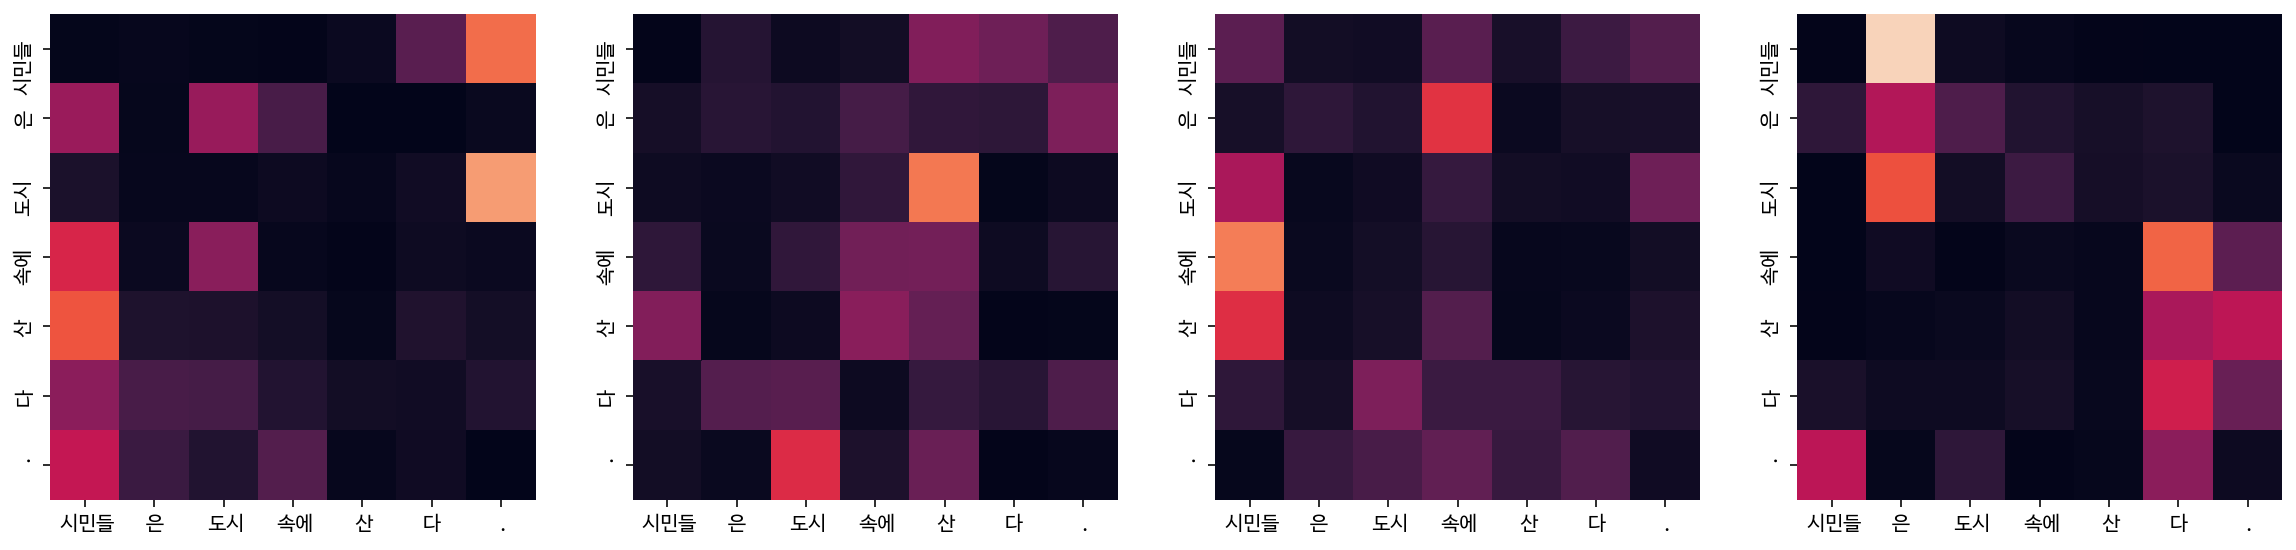

Decoder Self Layer 1


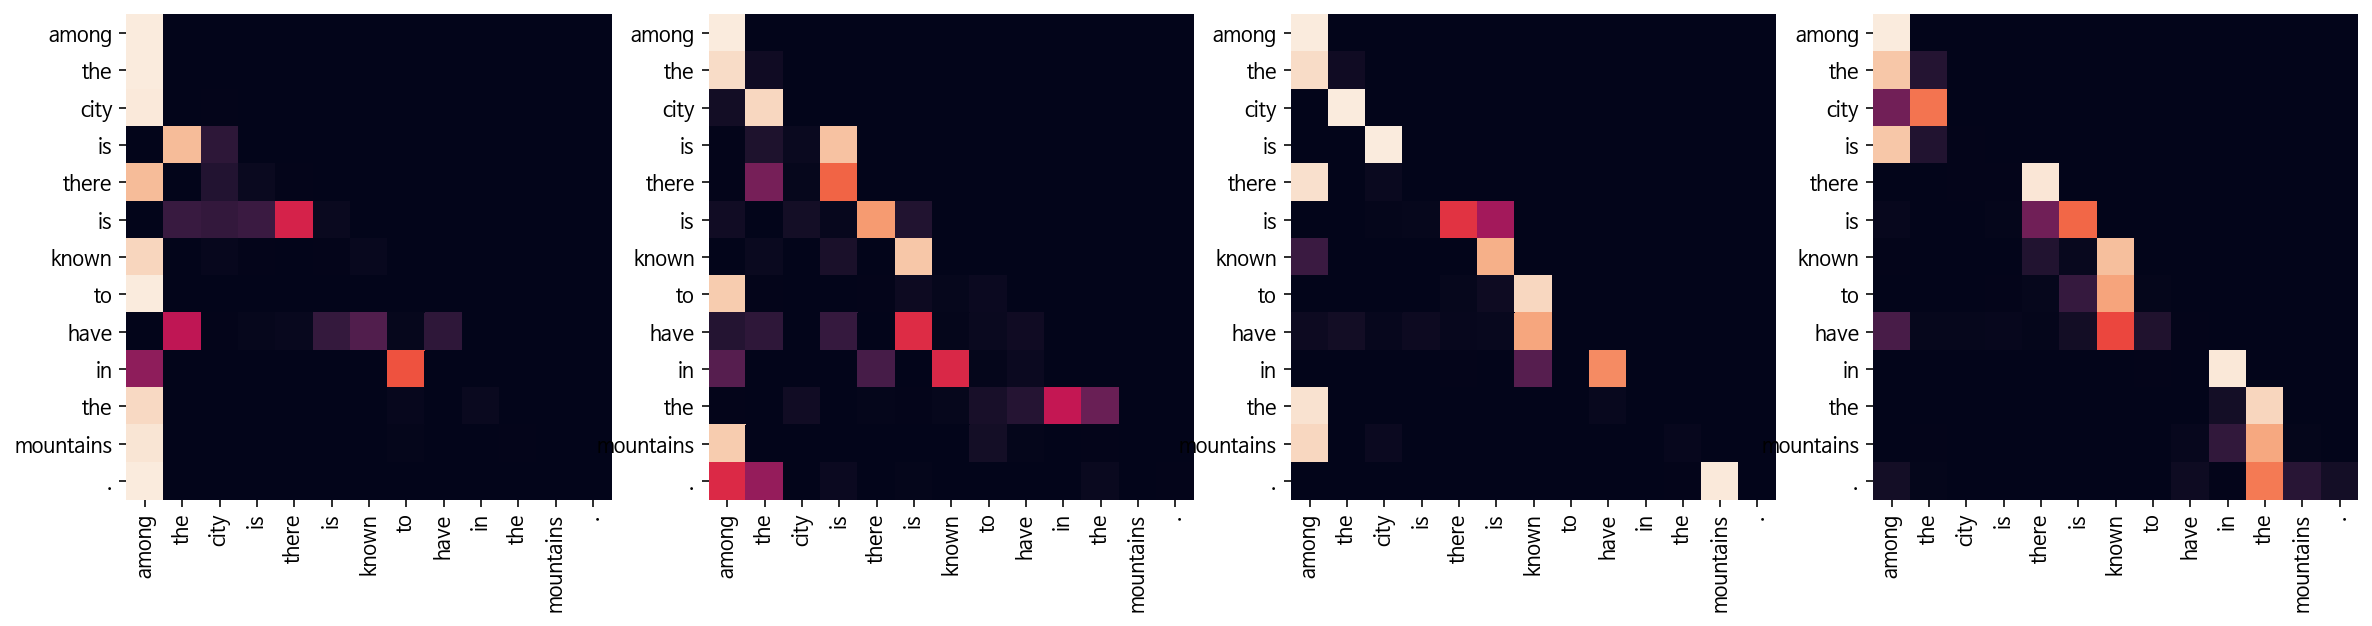

Decoder Src Layer 1


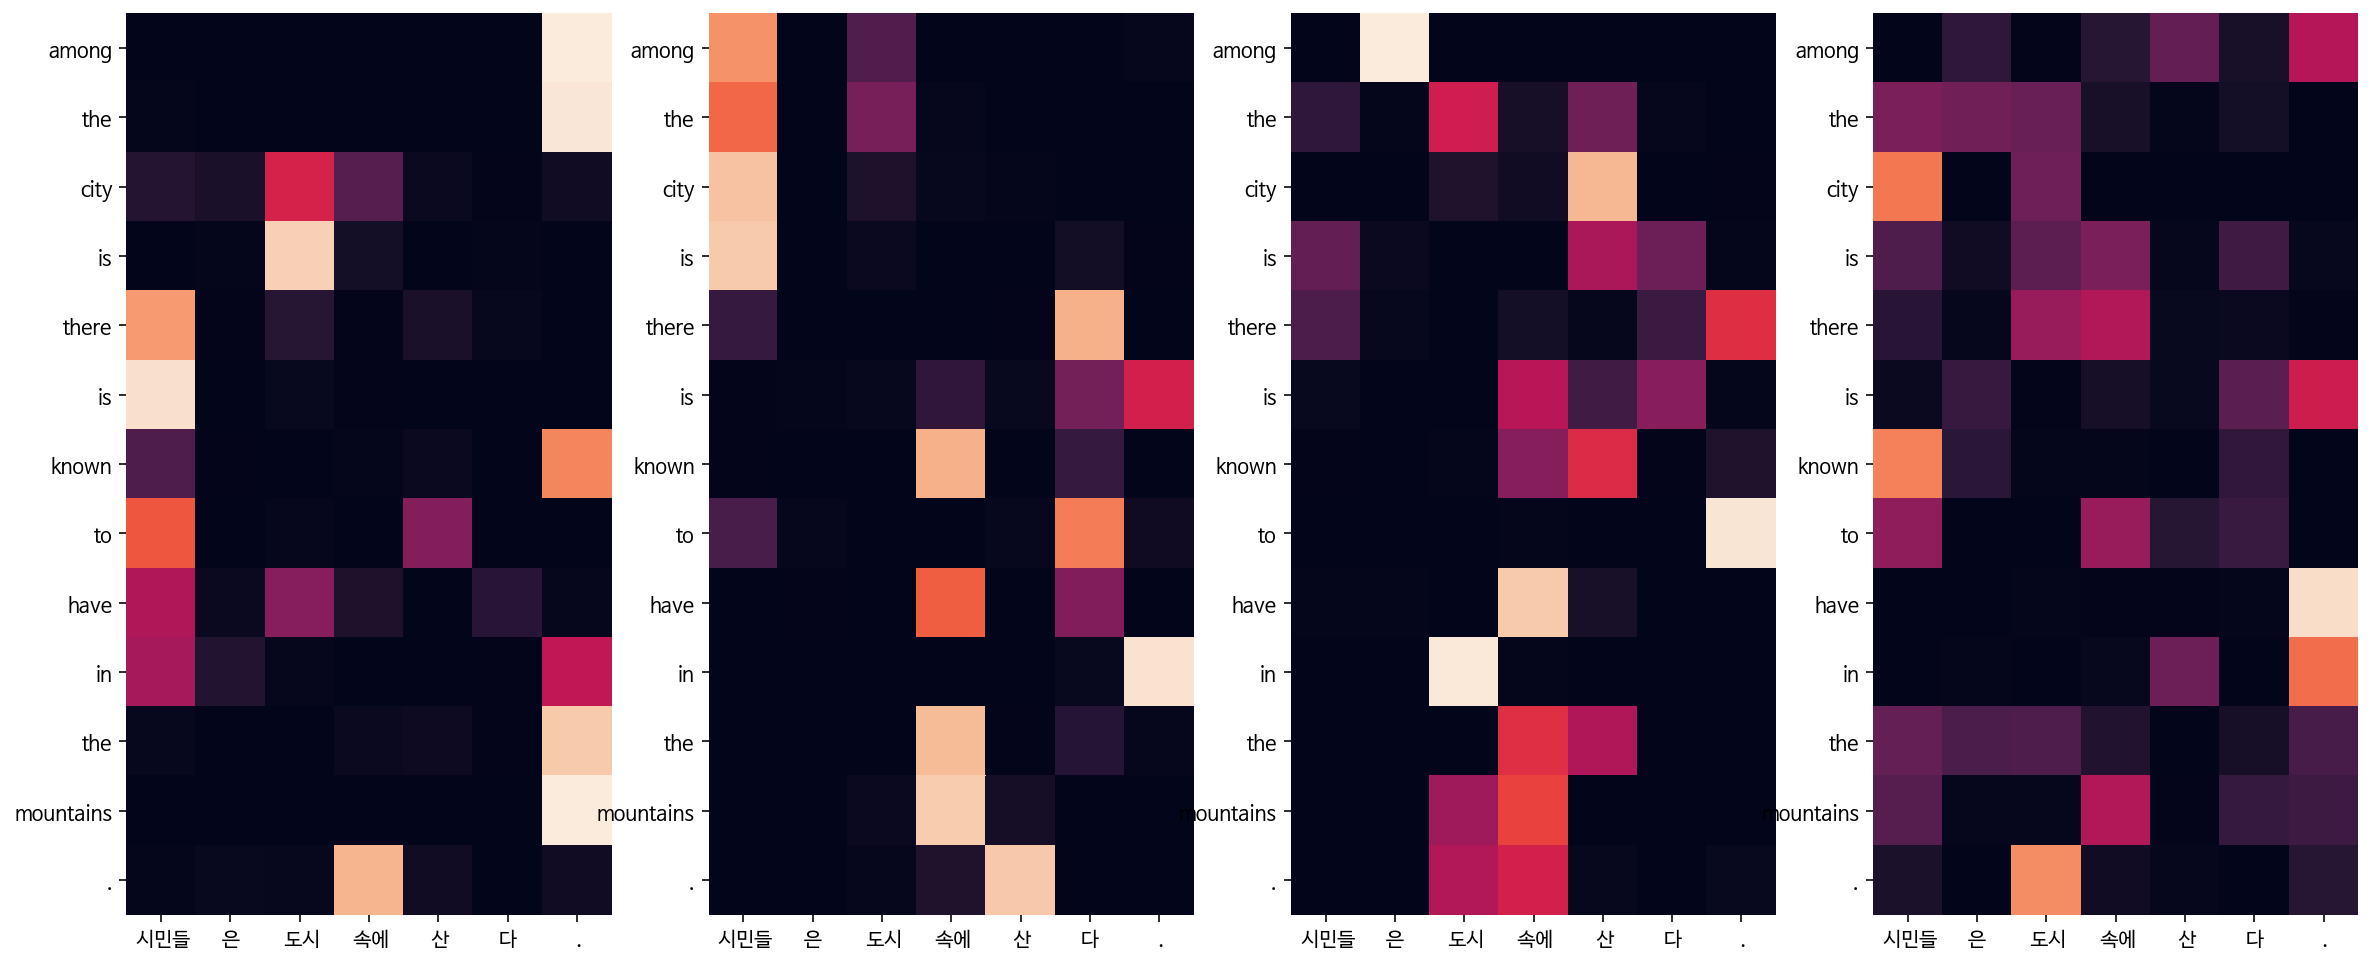

Decoder Self Layer 2


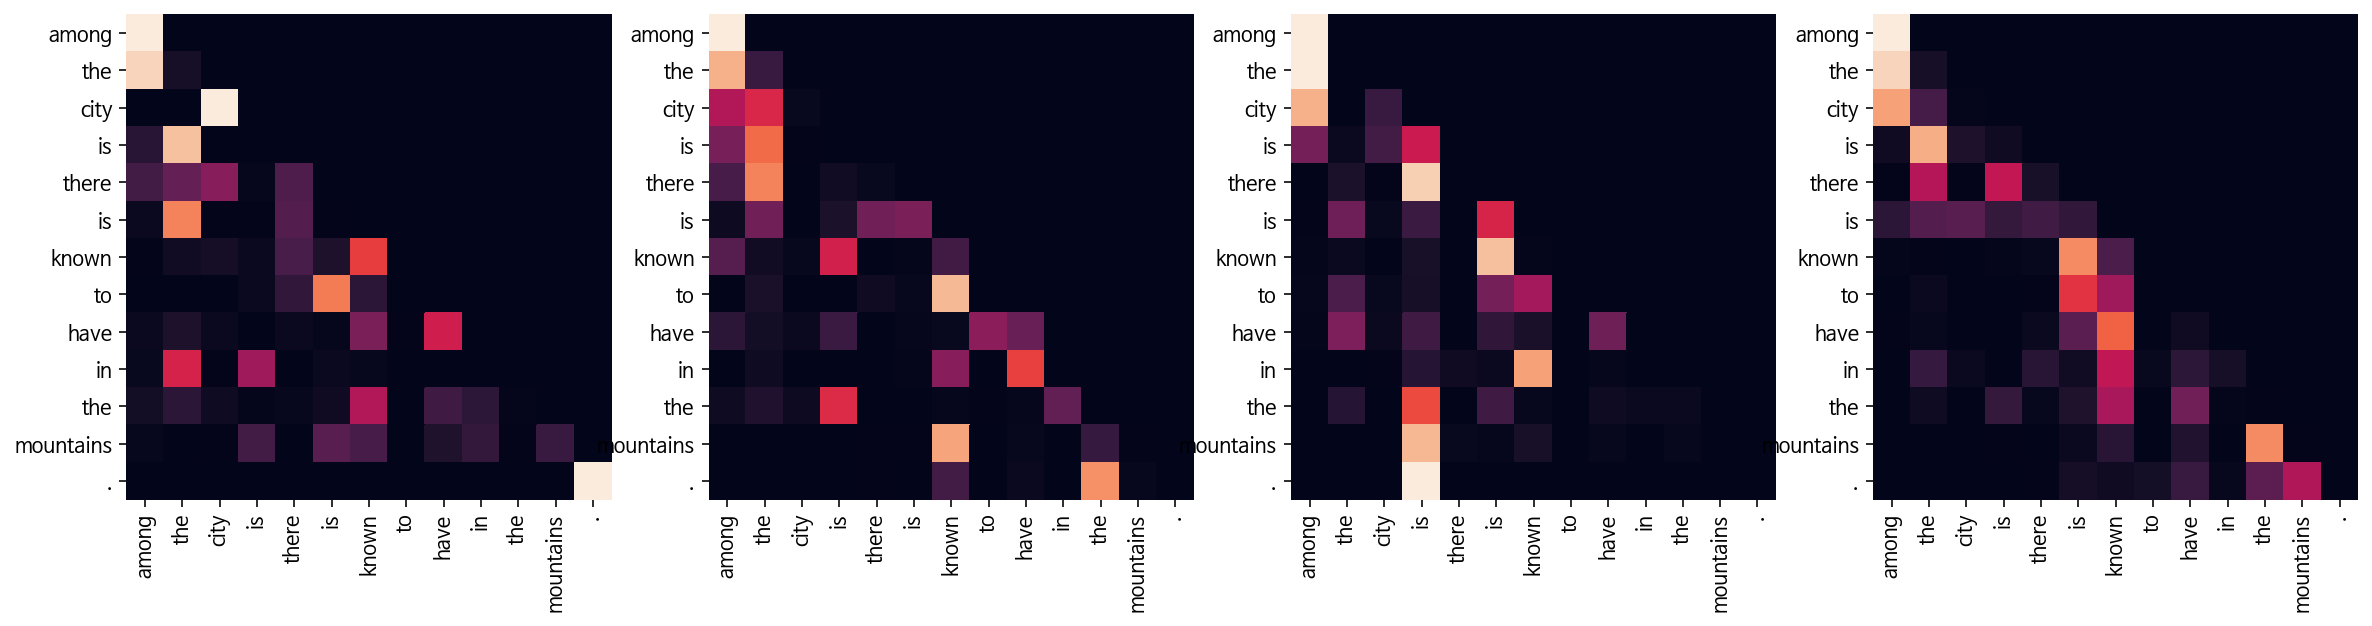

Decoder Src Layer 2


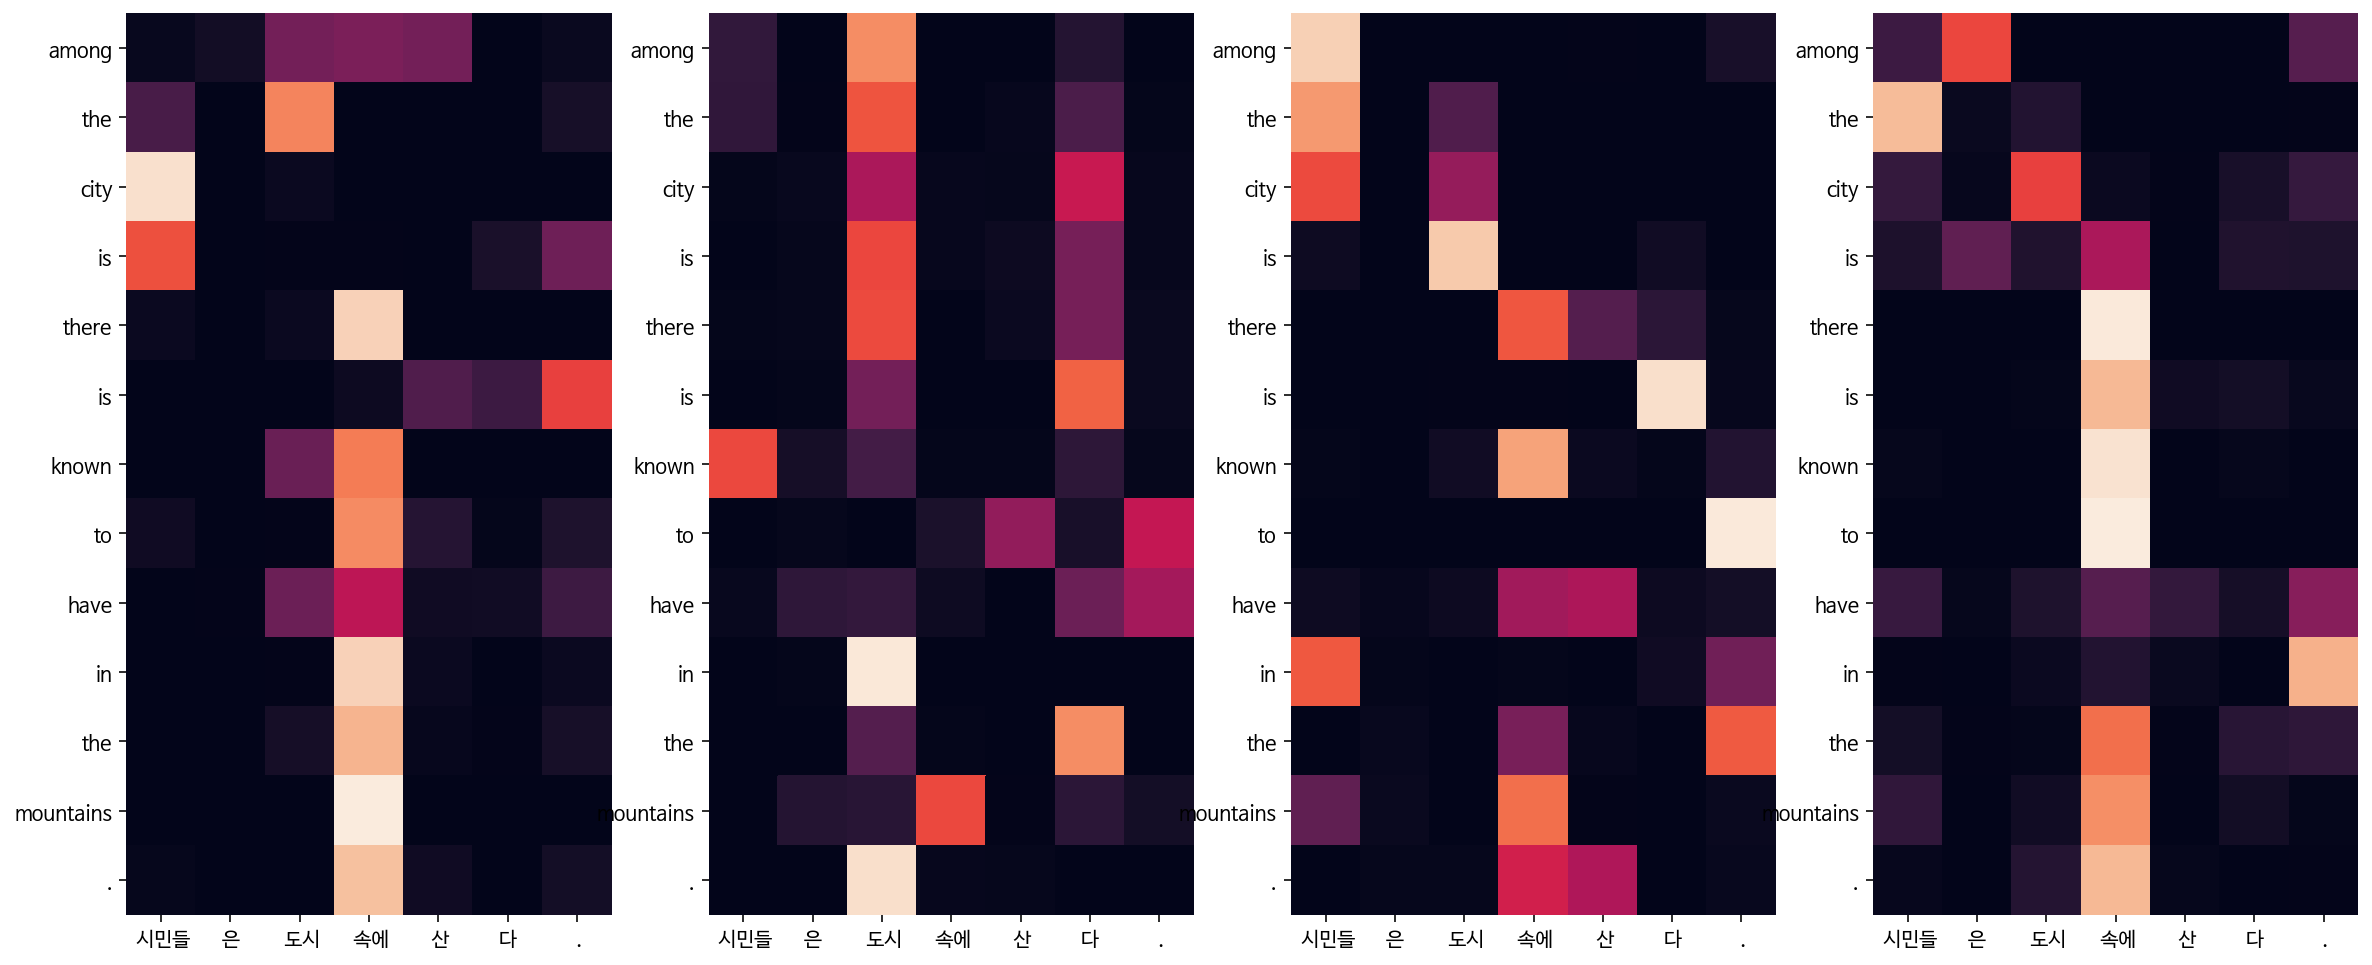

In [57]:
# 시민들은 도시 속에 산다.
translate('시민들은 도시 속에 산다.',transformer, ko_tokenizer, en_tokenizer,True)

Input: 커피는 필요 없다.
Predicted translation: the need is no alternative .
Encoder Layer 1


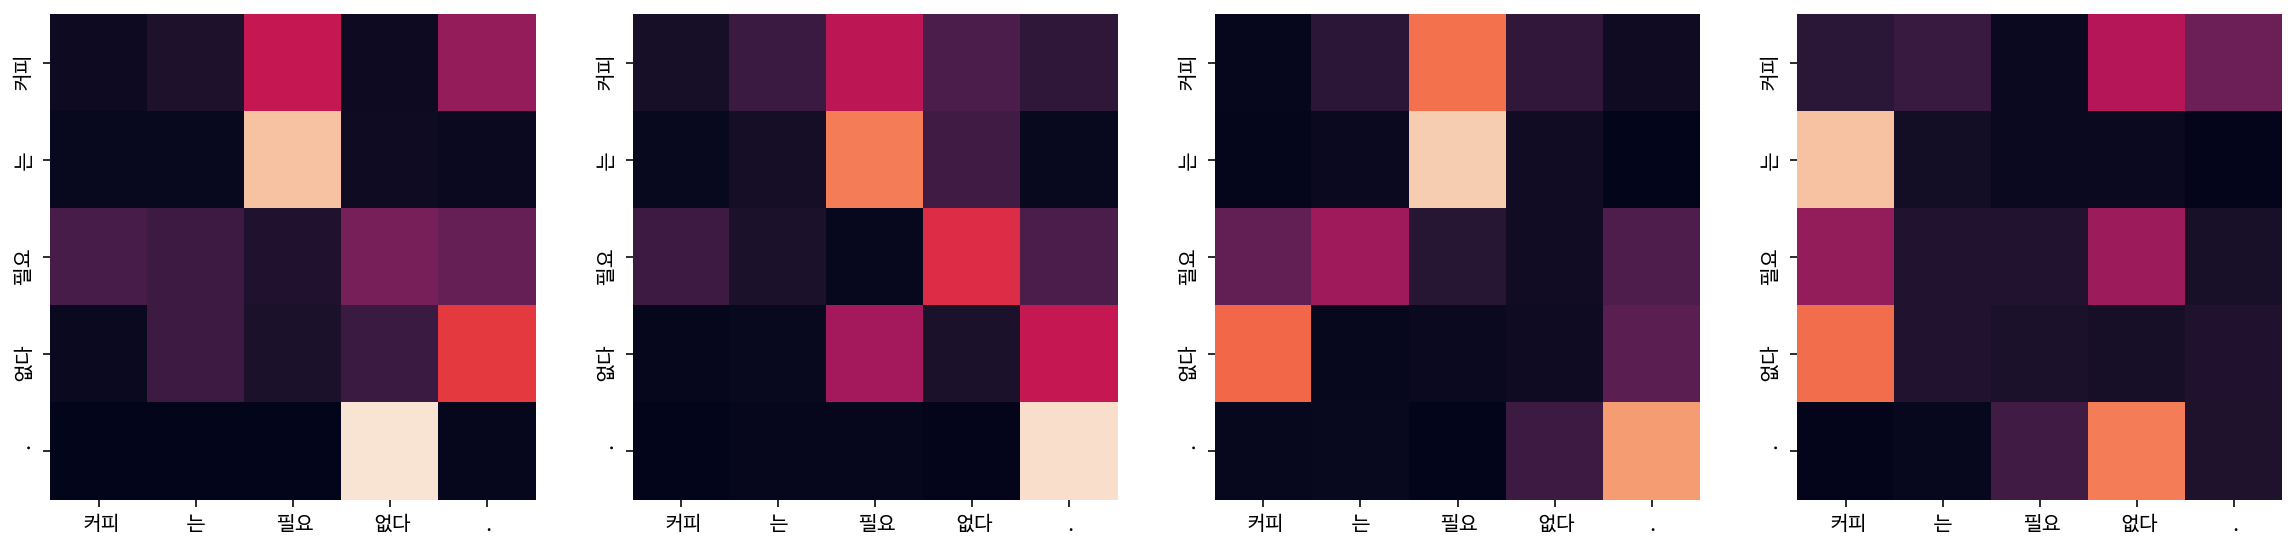

Encoder Layer 2


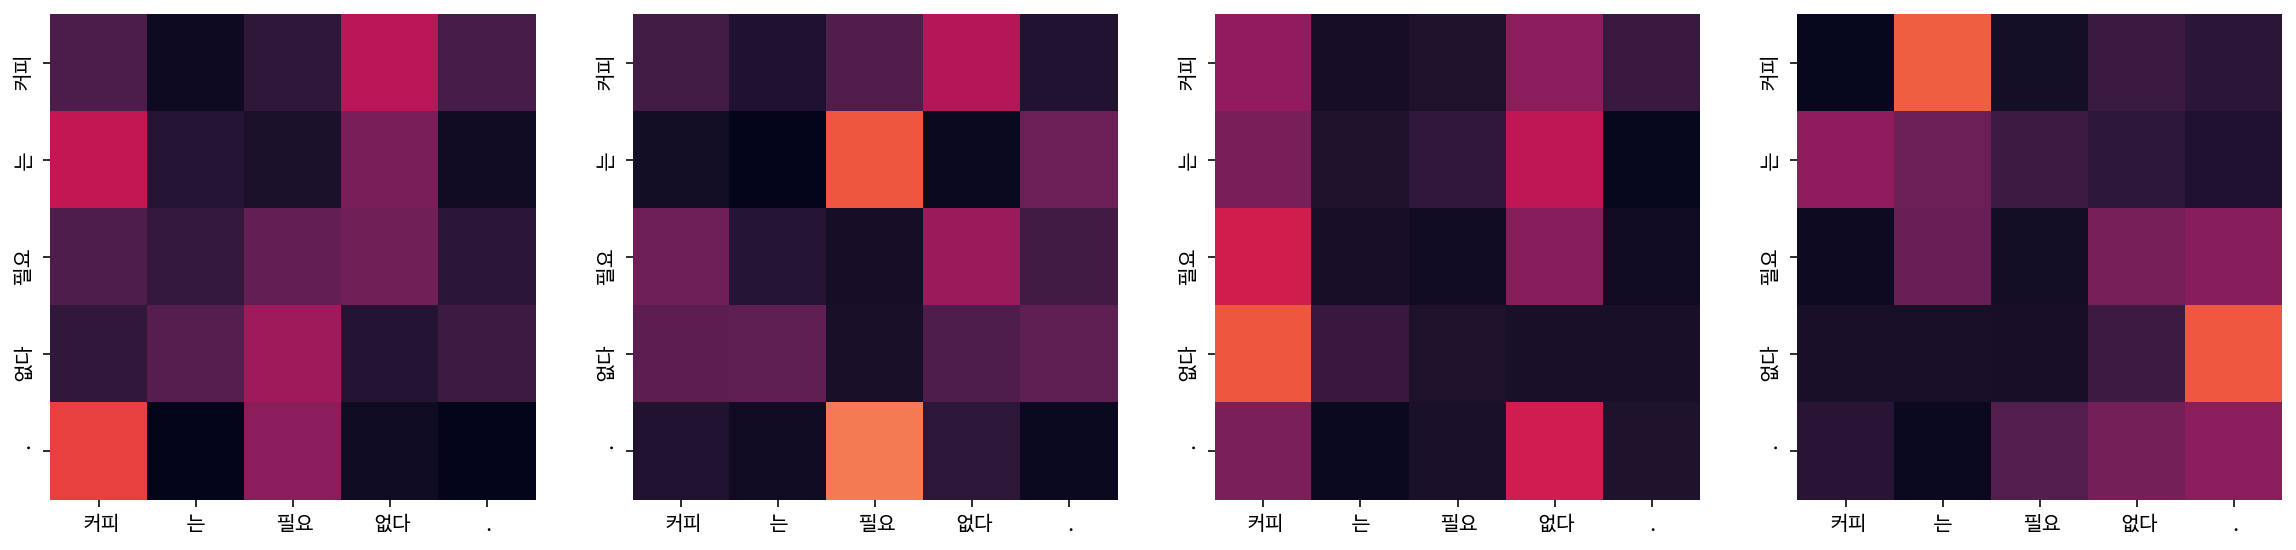

Decoder Self Layer 1


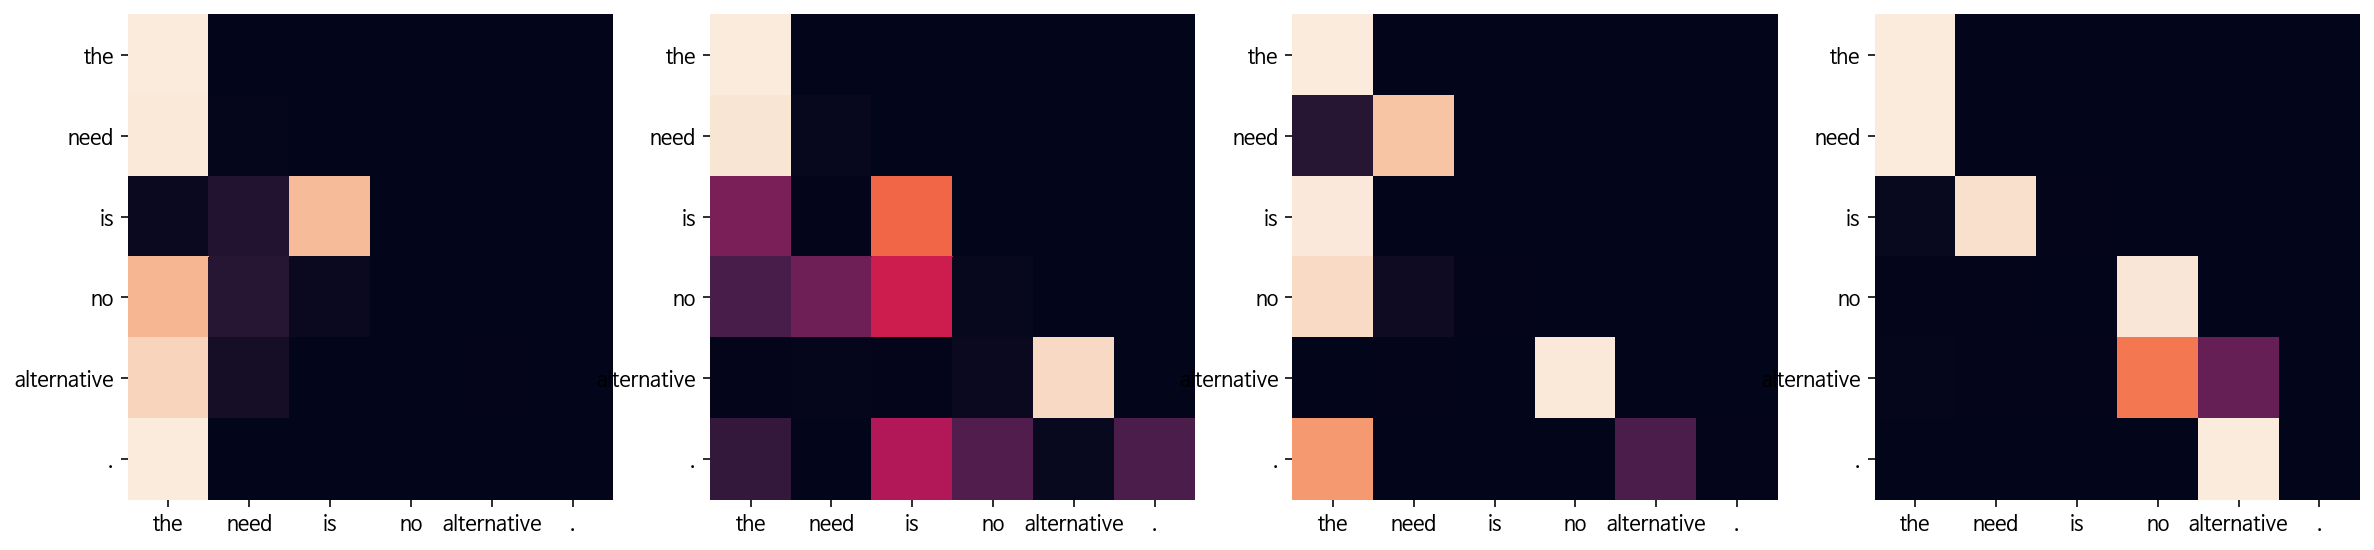

Decoder Src Layer 1


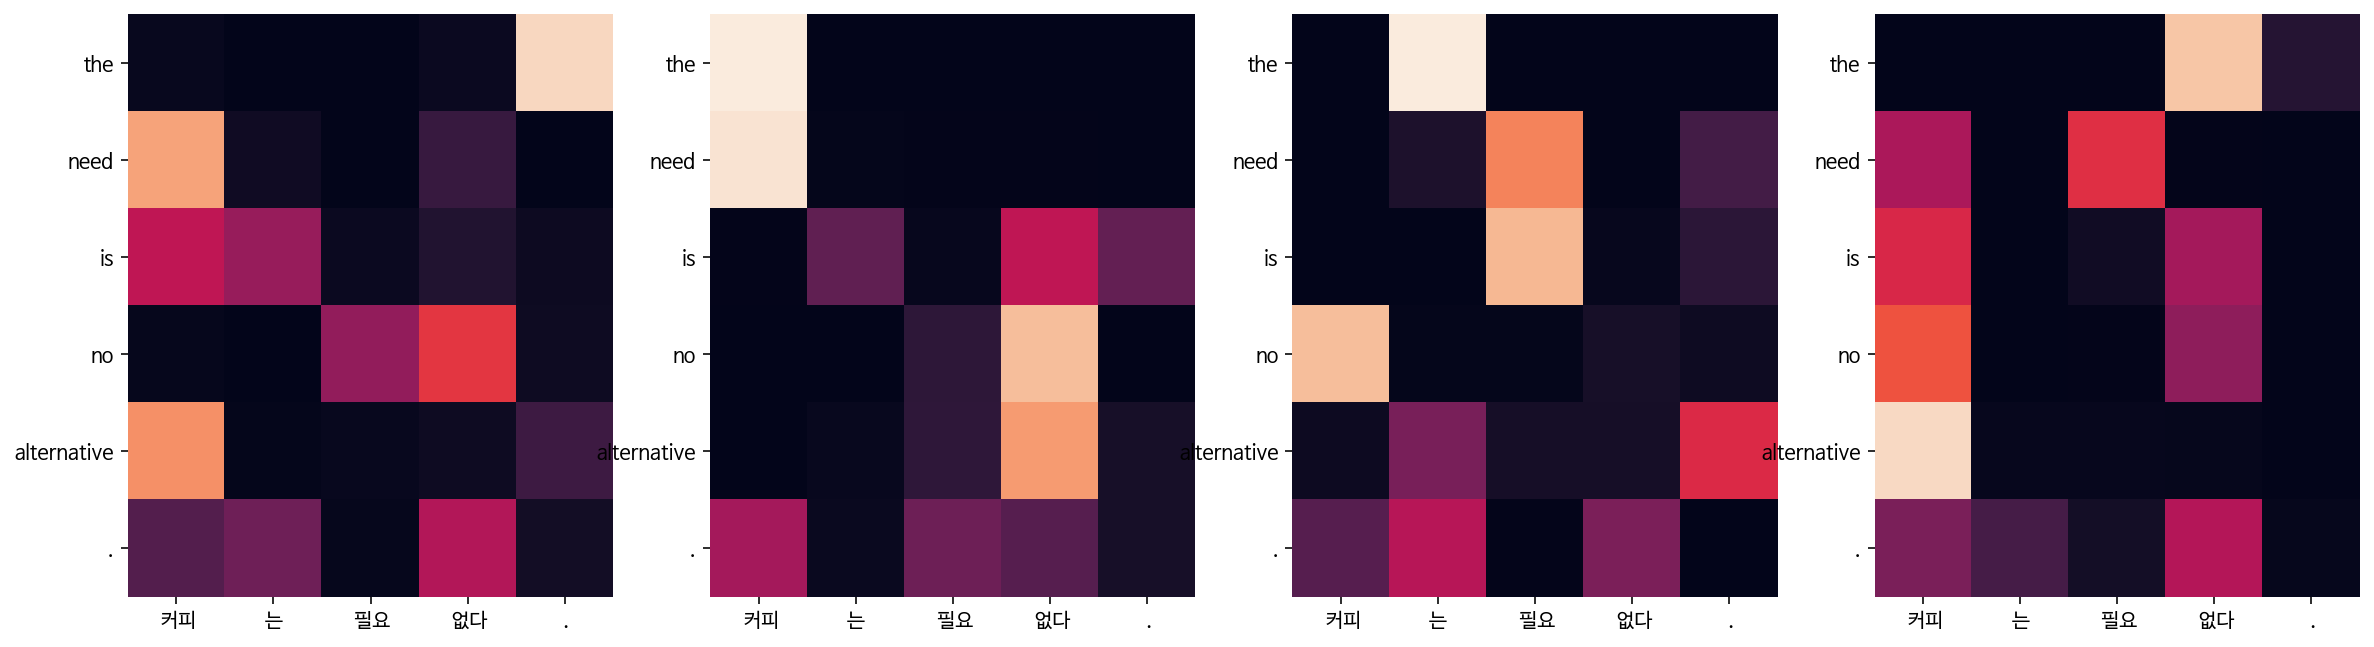

Decoder Self Layer 2


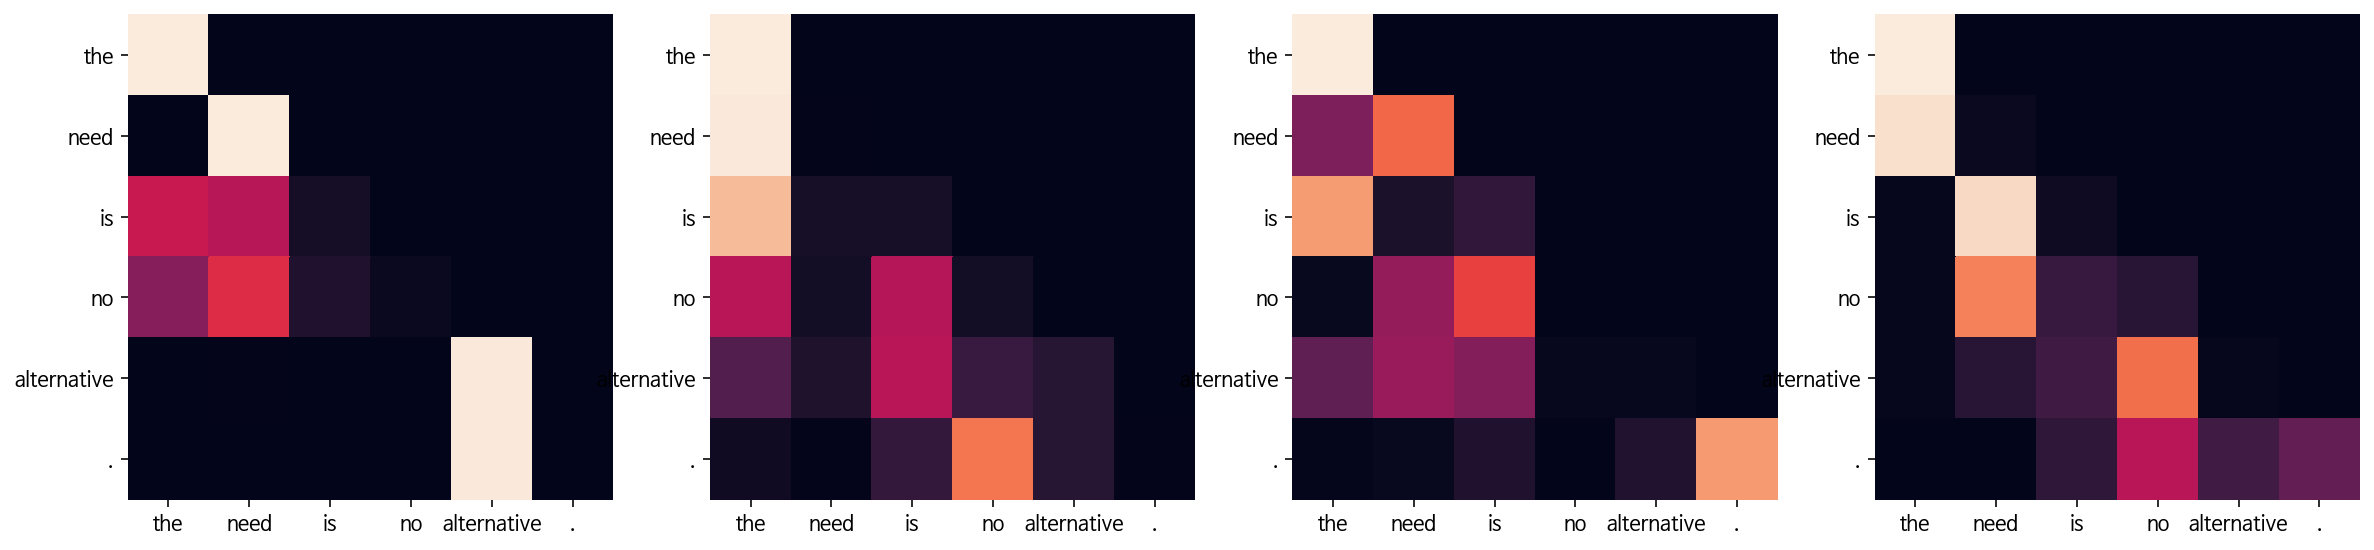

Decoder Src Layer 2


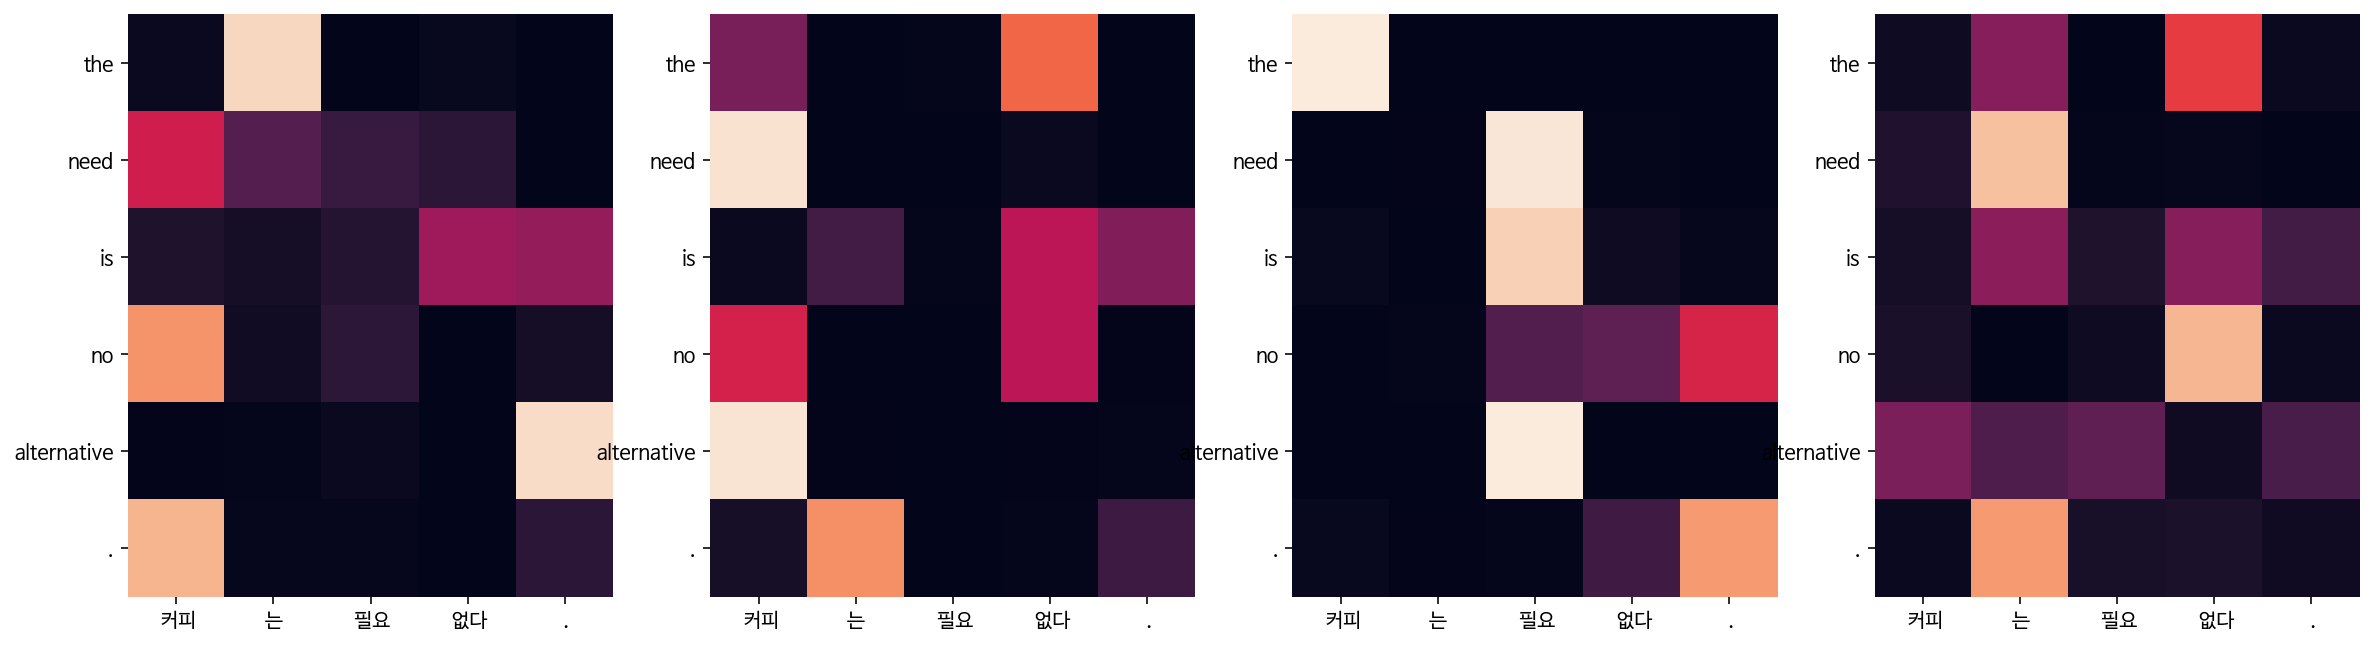

In [58]:
# 커피는 필요 없다.
translate('커피는 필요 없다.',transformer, ko_tokenizer, en_tokenizer,True)

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed when the plane occurred .
Encoder Layer 1


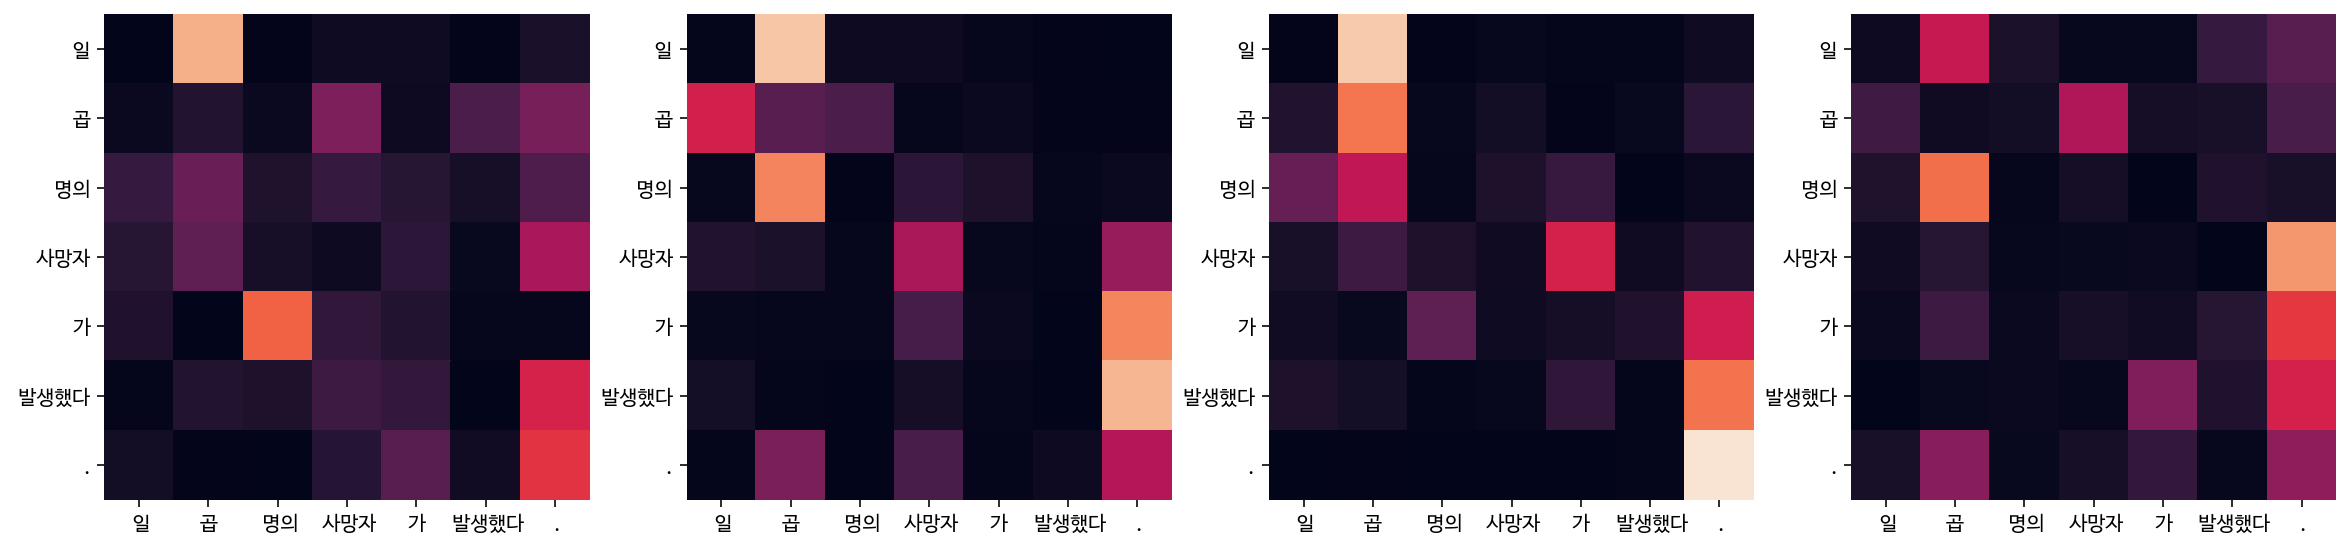

Encoder Layer 2


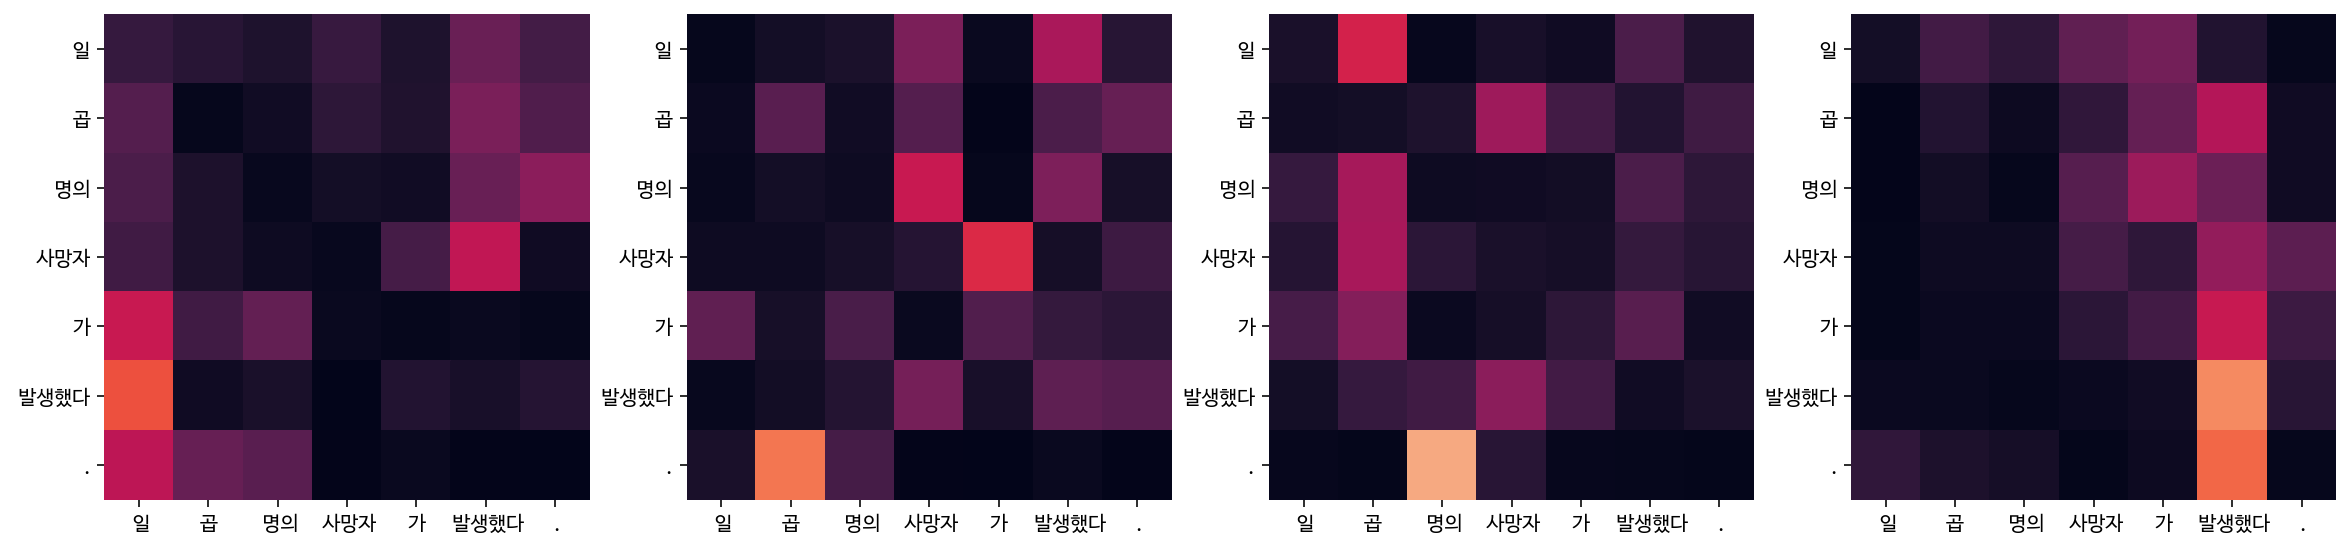

Decoder Self Layer 1


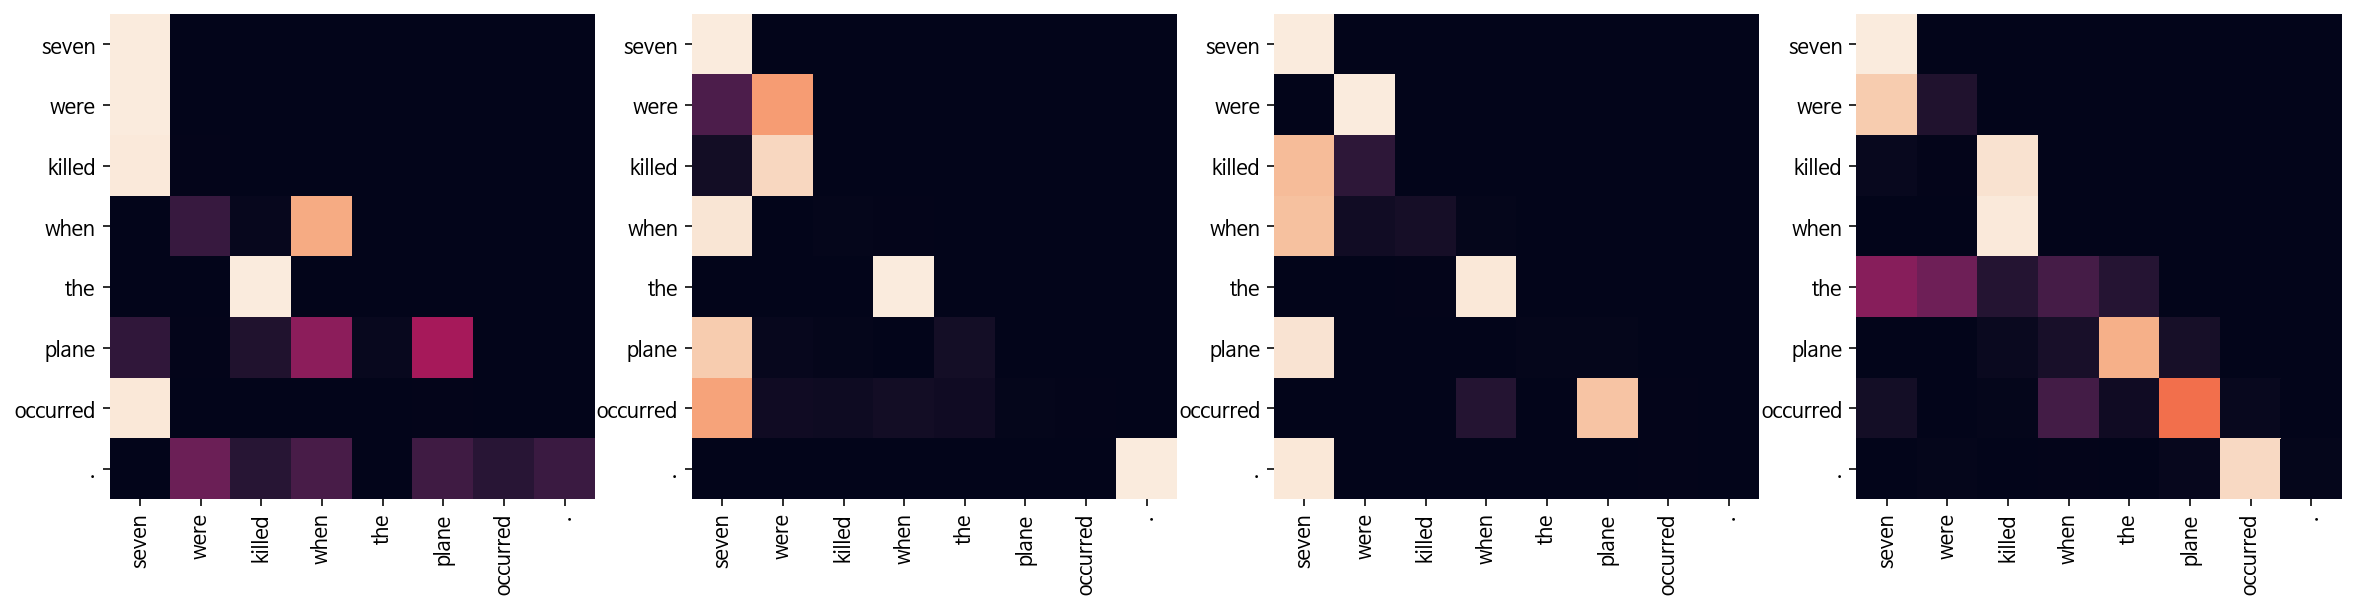

Decoder Src Layer 1


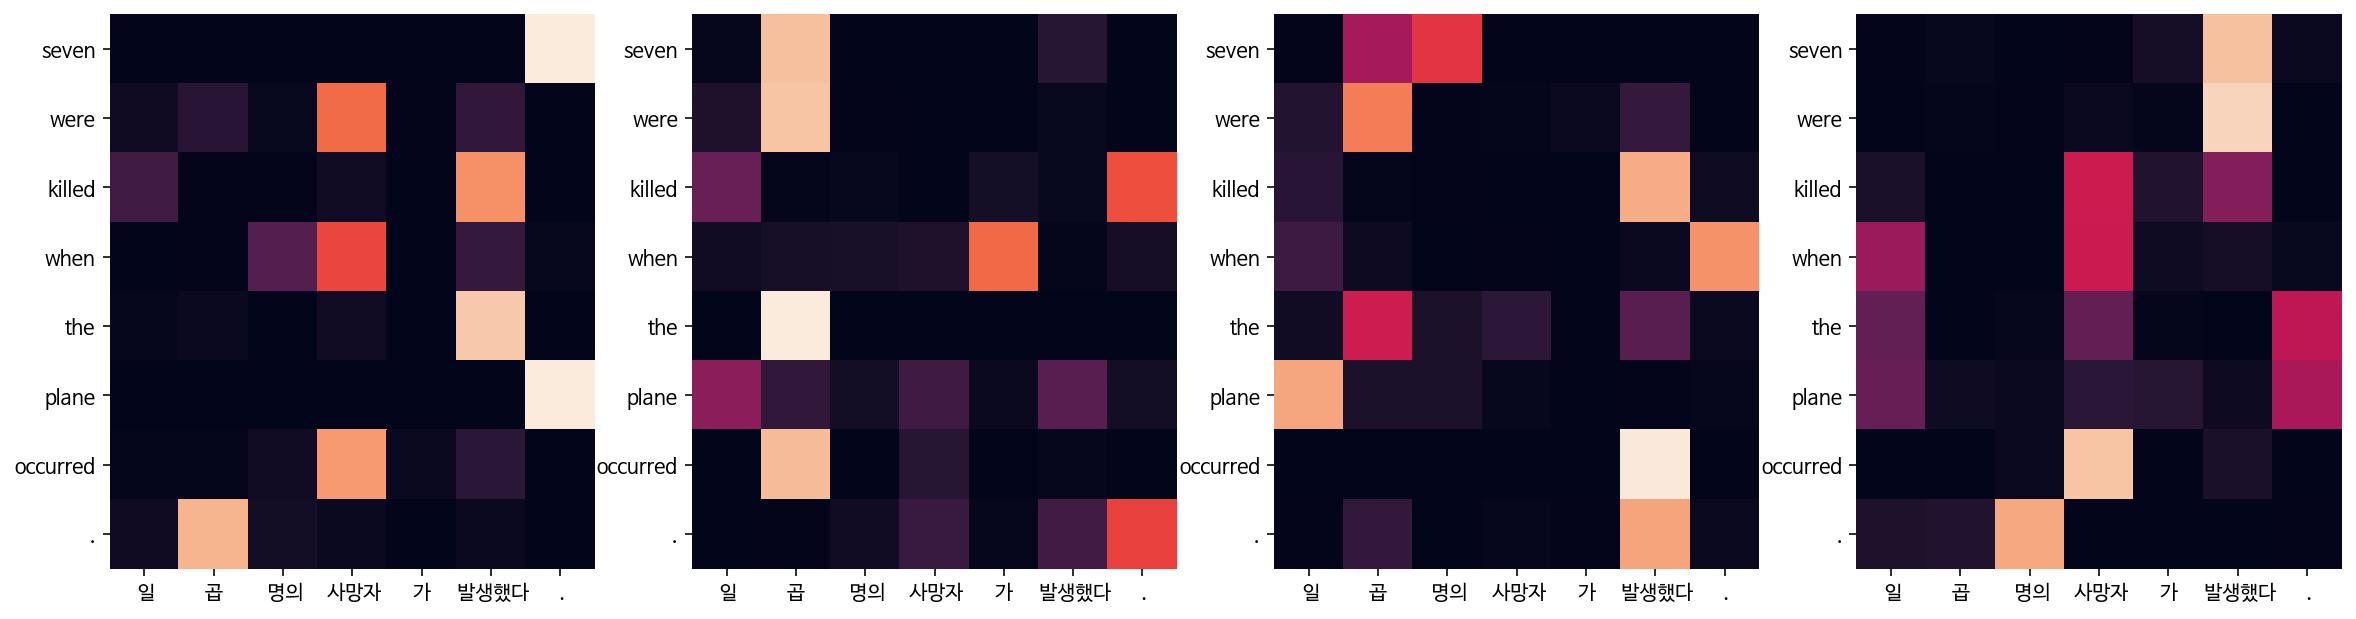

Decoder Self Layer 2


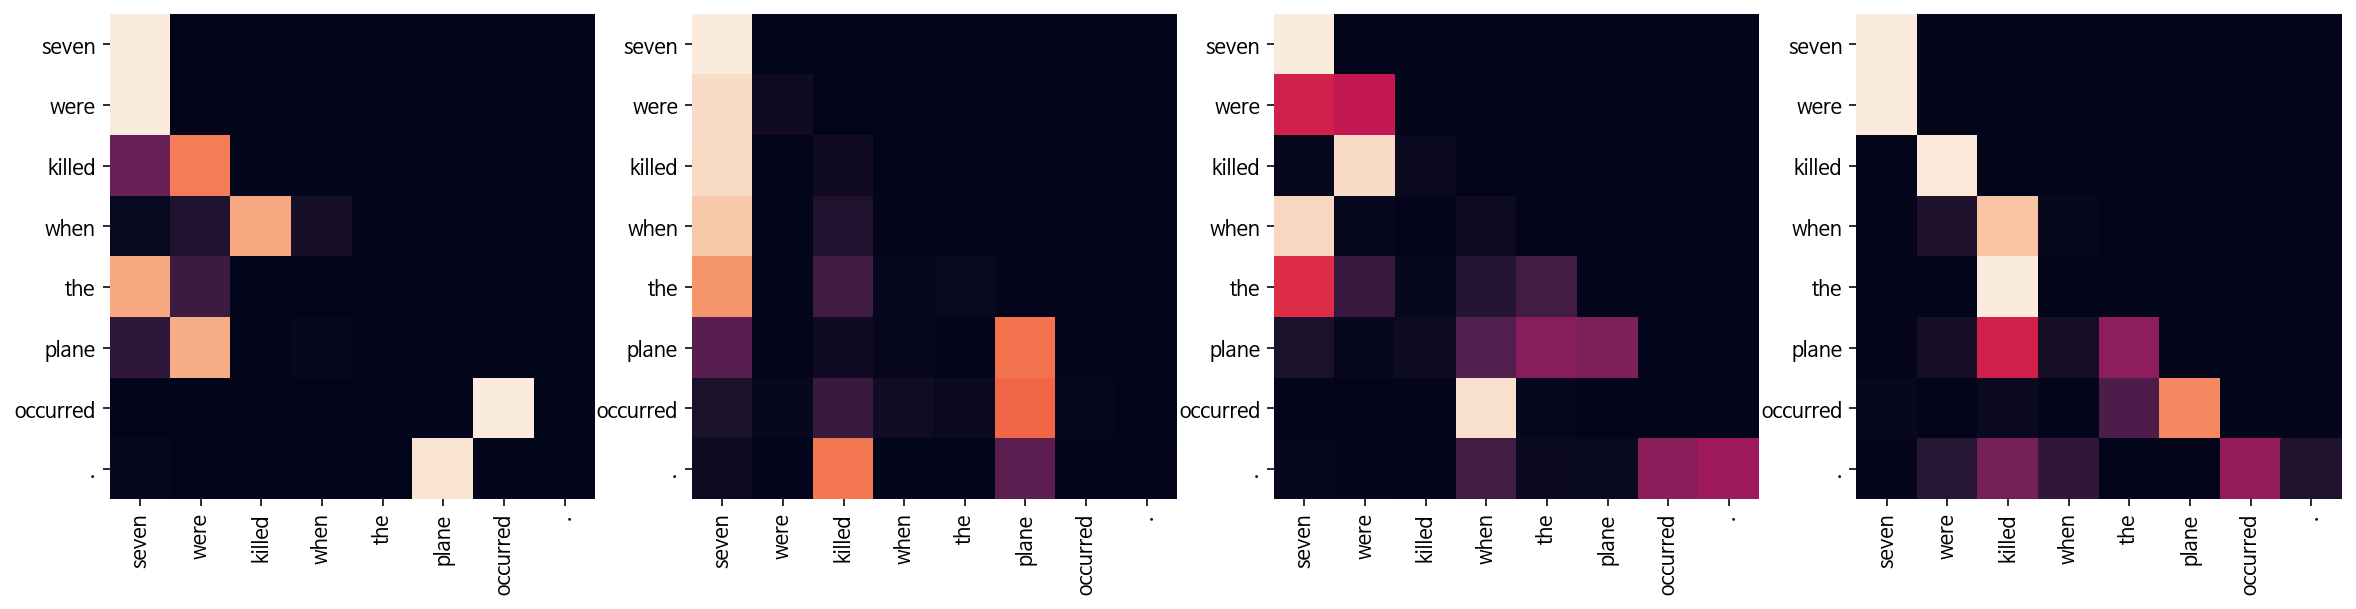

Decoder Src Layer 2


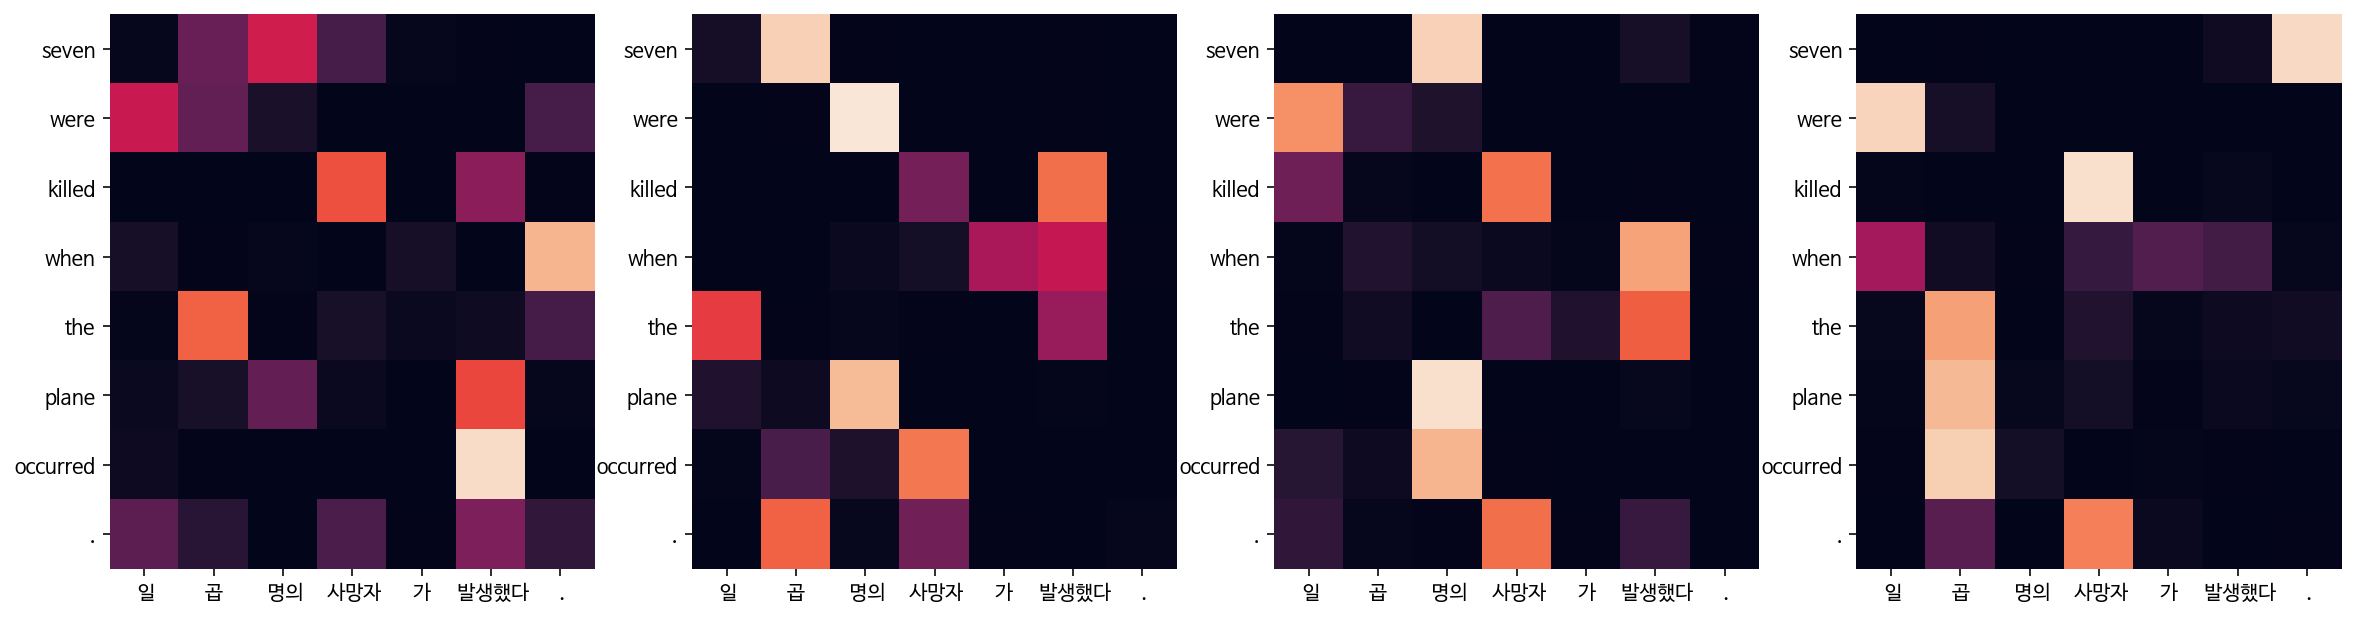

In [59]:
# 일곱 명의 사망자가 발생했다.
translate('일곱 명의 사망자가 발생했다.',transformer, ko_tokenizer, en_tokenizer,True)

---

# 루브릭

__1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.__  

- 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.

__2. Transformer 번역기 모델이 정상적으로 구동된다.__  

- Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.

__3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.__ 

- 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.

---

# 회고

- 많은 실험을 해보진 못 했지만 확실히 seq2seq에 비해 나은 결과가 도출됐다.
- 복잡한 트랜스포머에 대해서 코드 한줄 한줄까지는 이해할 수 없었지만 흐름 정도는 파악되었다.
- 시간적 여유가 된다면 하이퍼파라미터를 조정해서 다양하게 실험해 보고 싶다.